In this notebook I try to predict the winner of men's tennis matches (ATP). This data is from Jeff Sackmanns github (I downloaded it to my local machine). When doing some research, I saw alot of people using things like ELO and other ranking based systems for sports prediction. For no real reasons outside of trying to be different and desire to practice using some models in Python, I chose to not go this route and treat the situation as a classification problem. I restrict the data to just slams and masters tournaments (more important tournaments) and only since 2000. The data gets worse (more missing values) as you get earlier, and that still gave me 20 years of matches to consider. Basically all current players will be considered in this window, while not having so many retirements. Additionally, the further back we train on the more "out of sample" the new matches will be. That is, tennis changes over time, from playing styles to racquet technology. I didn't have a firm cutoff, but 2000 seemed appropriate. 

Trying to run a multinomial model or something like that with all of the different players seemed unfeasible while having predictions that might include new players at some point. So, I tried to have player agnostic models. That is, I ignore the name of the players in the match and only consider their statistics. I have two separate ideas:

1) Train a binary classification model like normal on past matches, including cross validation. Then, for new matches, use some method of finding the players "form" and that is the projected statistics for the match that will be used for prediction. An example would be a rolling average of each players statistics on the specified surface type. These rolling averages are then used to predict the new match

2) Find the players "forms" through similar methods to 1 (rolling average, EWA, etc), then train the model and predict. 

Option 1 fits to the actual matches better. If the statistics actually are good predictors for who won a match (they should be, although I might have the wrong statistics or need to engineer them or something), then training on the statistics as they actually happened will produce a model that describes the process of who won better. The problem is then what to do with new matches. The form finding will lead to error, as a rolling average certainly won't produce the exact statistics that happen in the match.

Option 2 is a more consistent methodology. Using the same data transformation for both training and new matches is good practice and will lead to answers that make more sense. The problem is still that form finding methods won't capture the relationship between the statistics and who won as well. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlite3 import Error
from datetime import datetime as dt
import random
import os
import re
import xgboost as xgb
from timeit import default_timer as timer
import time
import itertools
import warnings

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import GenericUnivariateSelect, SelectFdr, chi2, f_classif
from sklearn.naive_bayes import GaussianNB

# Cleaning

In [3]:
#read in data
PATH=r'C:\Users\andyk\OneDrive\Documents\Python_Scripts\ATP'
matches_PATH=os.path.join(PATH, 'all_matches.csv')
rankings_PATH=os.path.join(PATH, 'rankings.csv')
errors_PATH=os.path.join(PATH, 'overview.csv')

matches_df=pd.read_csv(matches_PATH).drop(["file"], axis=1)
rankings_df=pd.read_csv(rankings_PATH).drop(["file"], axis=1)
errors_df=pd.read_csv(errors_PATH)
errors_df.head()

C:\Users\andyk\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,match_id,player_p1,serve_pts_p1,aces_p1,dfs_p1,first_in_p1,first_won_p1,second_in_p1,second_won_p1,bk_pts_p1,...,unforced_fh_p2,unforced_bh_p2,tourney_date,M/W,Tournament,Round,p1,p2,players,sorted_players
0,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,69,2,1,32,25,37,21,5,...,15,9,19751219,M,Davis Cup World Group F,RR,Bjorn Borg,Jiri Hrebec,"['Bjorn Borg', 'Jiri Hrebec']","['Bjorn Borg', 'Jiri Hrebec']"
1,19780125-M-Pepsi_Grand_Slam-SF-Brian_Gottfried...,1,55,0,1,32,21,23,9,9,...,7,12,19780125,M,Pepsi Grand Slam,SF,Brian Gottfried,Bjorn Borg,"['Brian Gottfried', 'Bjorn Borg']","['Bjorn Borg', 'Brian Gottfried']"
2,19800705-M-Wimbledon-F-John_Mcenroe-Bjorn_Borg,1,180,12,3,111,75,69,44,14,...,36,43,19800705,M,Wimbledon,F,John Mcenroe,Bjorn Borg,"['John Mcenroe', 'Bjorn Borg']","['Bjorn Borg', 'John Mcenroe']"
3,19810607-M-Roland_Garros-F-Bjorn_Borg-Ivan_Lendl,1,73,7,2,46,27,27,17,9,...,23,10,19810607,M,Roland Garros,F,Bjorn Borg,Ivan Lendl,"['Bjorn Borg', 'Ivan Lendl']","['Bjorn Borg', 'Ivan Lendl']"
4,19810704-M-Wimbledon-F-John_Mcenroe-Bjorn_Borg,1,150,8,8,112,85,38,16,12,...,14,7,19810704,M,Wimbledon,F,John Mcenroe,Bjorn Borg,"['John Mcenroe', 'Bjorn Borg']","['Bjorn Borg', 'John Mcenroe']"


In [4]:
rankings_df.head()

,Unnamed: 0,1,104745,20200106,9985,player,points,rank,ranking_date
0,0,NaN,NaN,NaN,NaN,101736.0,4135.0,1.0,20000110.0
1,1,NaN,NaN,NaN,NaN,102338.0,2915.0,2.0,20000110.0
2,2,NaN,NaN,NaN,NaN,101948.0,2419.0,3.0,20000110.0
3,3,NaN,NaN,NaN,NaN,103017.0,2184.0,4.0,20000110.0
4,4,NaN,NaN,NaN,NaN,102856.0,2169.0,5.0,20000110.0


In [5]:
#convert some columns to floats
numeric_columns = ['w_ace', 'l_ace', 'w_df', 'l_df', 'w_bpSaved', 'l_bpSaved', 'winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 'w_svpt', 'l_svpt', 'minutes']
matches_df[numeric_columns] = matches_df[numeric_columns].astype(float)

matches_df.head()

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed,tournament_date,Year,players,sorted_players
0,3,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,202866,AUS,Doug Smith,NaN,NaN,NaN,1968-07-08,1968,"['Doug Smith', 'Peter Ledbetter']","['Doug Smith', 'Peter Ledbetter']"
1,3,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126914,RSA,Louis Pretorius,NaN,NaN,NaN,1968-07-08,1968,"['Louis Pretorius', 'Maurice Pollock']","['Louis Pretorius', 'Maurice Pollock']"
2,3,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209523,IRL,Cecil Pedlow,NaN,NaN,NaN,1968-07-08,1968,"['Cecil Pedlow', 'John Mulvey']","['Cecil Pedlow', 'John Mulvey']"
3,3,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100084,NED,Tom Okker,NaN,NaN,NaN,1968-07-08,1968,"['Tom Okker', 'Unknown Fearmon']","['Tom Okker', 'Unknown Fearmon']"
4,3,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100132,USA,Armistead Neely,NaN,NaN,NaN,1968-07-08,1968,"['Armistead Neely', 'Harry Sheridan']","['Armistead Neely', 'Harry Sheridan']"


### Add winners and errors

In [6]:
#cut out some years. The data is cleaner and the sport has changed over time so a decent cutoff. Could tweak
since_2000=matches_df[matches_df["Year"]>=2000]
since_2000["surface"].value_counts()
#only slams and masters 1000 (more important tournaments)
slams_and_masters=since_2000[(since_2000["tourney_level"]=="G")|(since_2000["tourney_level"]=="M")].reset_index()

In [7]:
#combine error/winner df with other data
#THIS ISNT WORKING
#but also I think the data is just bad (only 10% as much data and not all is in the right time range)
#slams_and_masters=sm.merge(errors_df, left_on=["sorted_players", "tourney_date"], right_on=["sorted_players", "tourney_date"])
#slams_and_masters.shape
#slams_and_masters=sm.copy()

### Correct Columns, remove null values

In [8]:
U_hand=slams_and_masters["winner_name"][slams_and_masters["winner_hand"]=="U"].values
#print(slams_and_masters[slams_and_masters["loser_name"].isin(U_hand)])


#copy pasted using since_2000.columns
#removed id, and entry
winner_cols=['w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df',
       'w_svpt', 'winner_age', 'winner_hand', 'winner_ht',
             'winner_ioc', 'winner_rank',
       'winner_rank_points', 'winner_seed']
loser_cols=['l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'loser_age',
            'loser_hand', 'loser_ht', 'loser_ioc',
            'loser_rank', 'loser_rank_points', 'loser_seed']

names=["winner_name", "loser_name"]

error_cols=["winners_p1", "winners_fh_p1", "winners_bh_p1", "unforced_p1", "unforced_fh_p1", "unforced_bh_p1",
           "winners_p2", "winners_fh_p2", "winners_bh_p2", "unforced_p2", "unforced_fh_p2", "unforced_bh_p2"]
#other potentially relevant columns
other_cols=["best_of", "draw_size", "minutes", "round", "score", "surface", "tourney_level", "Year", "tournament_date"]

#combine the above lists
good_cols=winner_cols+loser_cols+other_cols+names

#only the relevant columns
good_col_matches=slams_and_masters[good_cols]
#win=1 means player 1 won
good_col_matches["Win"]=1
pd.set_option('display.max_columns', 500)
slams_and_masters[(slams_and_masters["Year"]==2018)&(slams_and_masters["tourney_name"]=="Monte Carlo Masters")]

C:\Users\andyk\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed,tournament_date,Year,players,sorted_players
19739,171576,3,64,55.0,33.0,28.0,16.0,5.0,16.0,10.0,5.0,116.0,32.287474,NaN,R,180.0,104655,URU,Pablo Cuevas,41.0,1210.0,NaN,239,170.0,R64,5-7 7-6(4) 6-1,Clay,20180416,2018-0410,M,Monte Carlo Masters,77.0,52.0,10.0,15.0,4.0,12.0,8.0,6.0,110.0,34.417522,NaN,L,188.0,104269,ESP,Fernando Verdasco,37.0,1280.0,NaN,2018-04-16,2018,"['Fernando Verdasco', 'Pablo Cuevas']","['Fernando Verdasco', 'Pablo Cuevas']"
19740,171577,3,64,36.0,16.0,4.0,8.0,0.0,8.0,2.0,2.0,50.0,25.905544,NaN,R,172.0,106000,BIH,Damir Dzumhur,31.0,1415.0,NaN,240,71.0,R64,6-3 6-2,Clay,20180416,2018-0410,M,Monte Carlo Masters,45.0,29.0,9.0,9.0,1.0,6.0,3.0,2.0,64.0,25.541410,Q,R,NaN,106065,ITA,Marco Cecchinato,100.0,606.0,NaN,2018-04-16,2018,"['Marco Cecchinato', 'Damir Dzumhur']","['Damir Dzumhur', 'Marco Cecchinato']"
19741,171578,3,64,57.0,39.0,22.0,13.0,2.0,11.0,8.0,8.0,107.0,21.637235,WC,R,NaN,200031,MON,Lucas Catarina,365.0,122.0,NaN,241,129.0,R64,3-6 6-2 6-3,Clay,20180416,2018-0410,M,Monte Carlo Masters,51.0,42.0,11.0,13.0,22.0,1.0,0.0,3.0,72.0,27.301848,NaN,R,196.0,105683,CAN,Milos Raonic,22.0,1765.0,14.0,2018-04-16,2018,"['Milos Raonic', 'Lucas Catarina']","['Lucas Catarina', 'Milos Raonic']"
19742,171579,3,64,35.0,17.0,21.0,13.0,1.0,12.0,6.0,6.0,73.0,32.577687,NaN,R,196.0,104607,CZE,Tomas Berdych,18.0,2140.0,12.0,242,105.0,R64,4-6 6-2 6-1,Clay,20180416,2018-0410,M,Monte Carlo Masters,36.0,28.0,17.0,12.0,3.0,4.0,2.0,3.0,65.0,28.295688,NaN,R,178.0,105453,JPN,Kei Nishikori,36.0,1280.0,NaN,2018-04-16,2018,"['Kei Nishikori', 'Tomas Berdych']","['Kei Nishikori', 'Tomas Berdych']"
19743,171580,3,64,55.0,39.0,31.0,16.0,1.0,14.0,10.0,6.0,115.0,26.184805,NaN,R,NaN,105916,HUN,Marton Fucsovics,59.0,864.0,NaN,243,165.0,R64,6-7(4) 6-2 7-5,Clay,20180416,2018-0410,M,Monte Carlo Masters,65.0,47.0,30.0,16.0,2.0,8.0,7.0,2.0,117.0,22.176591,NaN,R,NaN,106421,RUS,Daniil Medvedev,49.0,984.0,NaN,2018-04-16,2018,"['Daniil Medvedev', 'Marton Fucsovics']","['Daniil Medvedev', 'Marton Fucsovics']"
19744,171581,3,64,46.0,35.0,19.0,14.0,8.0,11.0,7.0,2.0,86.0,23.268994,NaN,R,NaN,106378,GBR,Kyle Edmund,23.0,1757.0,NaN,244,123.0,R64,6-3 5-7 6-2,Clay,20180416,2018-0410,M,Monte Carlo Masters,52.0,39.0,22.0,15.0,7.0,11.0,9.0,1.0,96.0,34.149213,Q,R,190.0,104312,ITA,Andreas Seppi,62.0,851.0,NaN,2018-04-16,2018,"['Andreas Seppi', 'Kyle Edmund']","['Andreas Seppi', 'Kyle Edmund']"
19745,171582,3,64,37.0,25.0,10.0,11.0,4.0,8.0,4.0,3.0,61.0,34.529774,LL,R,190.0,104252,GER,Florian Mayer,74.0,729.0,NaN,247,82.0,R64,7-5 6-4,Clay,20180416,2018-0410,M,Monte Carlo Masters,35.0,27.0,14.0,11.0,10.0,2.0,0.0,3.0,63.0,34.937714,NaN,L,193.0,104180,LUX,Gilles Muller,28.0,1465.0,NaN,2018-04-16,2018,"['Gilles Muller', 'Florian Mayer']","['Florian Mayer', 'Gilles Muller']"
19746,171583,3,64,34.0,17.0,10.0,9.0,3.0,8.0,3.0,4.0,59.0,29.574264,NaN,R,173.0,105216,JPN,Yuichi Sugita,43.0,1160.0,NaN,248,67.0,R64,6-3 6-2,Clay,20180416,2018-0410,M,Monte Carlo Masters,26.0,22.0,11.0,8.0,5.0,3.0,2.0,3.0,47.0,27.975359,NaN,R,NaN,105526,GER,Jan Lennard Struff,61.0,855.0,NaN,2018-04-16,2018,"['Jan Lennard Struff', 'Yuichi Sugita']","['Jan Lennard Struff', 'Yuichi Sugita']"
19747,171584,3,64,32.0,18.0,10.0,11.0,5.0,6.0,1.0,2.0,56.0,24.139630,Q,R,NaN,125802,BLR,Ilya Ivashka,122.0,458.0,NaN,249,86.0,R64,6-4 7-5,Clay,20180416,2018-0410,M,Monte Carlo Masters,40.0,24.0,13.0,11.0,1.0,4.0,1.0,2.0,61.0,30.896646,NaN,R,178.0,104926,ITA,Fabio Fognini,20.0,1840.0,13.0,2018-04-16,2018,"['Fabio Fognini', 'Ilya Ivashka'

In [9]:
#check for missing values in all columns
good_col_matches.isnull().sum()

w_1stIn                 171
w_1stWon                171
w_2ndWon                171
w_SvGms                 171
w_ace                   171
w_bpFaced               171
w_bpSaved               171
w_df                    171
w_svpt                  171
winner_age                0
winner_hand               0
winner_ht              1005
winner_ioc                0
winner_rank               4
winner_rank_points        4
winner_seed           10641
l_1stIn                 171
l_1stWon                171
l_2ndWon                171
l_SvGms                 171
l_ace                   171
l_bpFaced               171
l_bpSaved               171
l_df                    171
l_svpt                  171
loser_age                 0
loser_hand                0
loser_ht               1636
loser_ioc                 0
loser_rank               20
loser_rank_points        20
loser_seed            16044
best_of                   0
draw_size                 0
minutes                 663
round               

In [10]:
#drop seed columns because they are awful 
good_col_matches.drop(["winner_seed", "loser_seed"], axis=1, inplace=True)
w_cols=[x for x in winner_cols if x.startswith("w_")]
l_cols=[x for x in loser_cols if x.startswith("l_")]
print(w_cols)

['w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace', 'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt']


C:\Users\andyk\Anaconda3\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
#saw 171 nan in a subset of columns, so remove those rows 
#they are important columns
print(good_col_matches.shape)
good_col_matches.dropna(subset=w_cols+l_cols, how="all", inplace=True)
print(good_col_matches.shape)
#lost 171 rows, mission accomplished

(21699, 42)
(21528, 42)


C:\Users\andyk\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
good_col_matches.isnull().sum()

w_1stIn                  0
w_1stWon                 0
w_2ndWon                 0
w_SvGms                  0
w_ace                    0
w_bpFaced                0
w_bpSaved                0
w_df                     0
w_svpt                   0
winner_age               0
winner_hand              0
winner_ht             1000
winner_ioc               0
winner_rank              4
winner_rank_points       4
l_1stIn                  0
l_1stWon                 0
l_2ndWon                 0
l_SvGms                  0
l_ace                    0
l_bpFaced                0
l_bpSaved                0
l_df                     0
l_svpt                   0
loser_age                0
loser_hand               0
loser_ht              1628
loser_ioc                0
loser_rank              20
loser_rank_points       20
best_of                  0
draw_size                0
minutes                496
round                    0
score                    0
surface                  0
tourney_level            0
Y

#### Remove Carpet Surface

Carpet stopped being used in 2009. So while me useful in understanding/predicting old matches (esp matches on carpet) we won't be doing this so can just ignore these matches. There aren't too many anyway

In [13]:
good_col_matches.surface.value_counts()

Hard      12696
Clay       5973
Grass      2532
Carpet      327
Name: surface, dtype: int64

In [14]:
good_col_matches=good_col_matches[good_col_matches["surface"]!="Carpet"]

In [15]:
good_col_matches.surface.value_counts()

Hard     12696
Clay      5973
Grass     2532
Name: surface, dtype: int64

##### Fill missing values in height columns

In [16]:
win_names=np.unique(good_col_matches.loc[good_col_matches["winner_ht"].isnull(), "winner_name"].values)
lose_names=np.unique(good_col_matches.loc[good_col_matches["loser_ht"].isnull(), "loser_name"].values)

null_names=list(win_names)+list(lose_names)

#for name in null_names:
#    good_col_matches[(good_col_matches["winner_name"]==name)|(good_col_matches["loser_name"]==name)]

#print(good_col_matches.loc[(good_col_matches["winner_name"] in null_names)|(good_col_matches["loser_name"] in null_names), ["winner_ht", "loser_ht"]])

#print(len(null_names), null_names)
def count_nulls(series):
    return len(series) - series.count()

def fill_hts(ht_df):
    null_win=ht_df.loc[ht_df["winner_ht"].isnull(), "winner_name"]
    null_lose=ht_df.loc[ht_df["loser_ht"].isnull(), "loser_name"]

def fix_hts(df):
    df_win=df[["winner_name", "winner_ht"]].copy()
    df_lose=df[["loser_name", "loser_ht"]].copy()
    cols=["name", "ht"]
    df_win.columns=cols
    df_lose.columns=cols
    hts=pd.concat([df_win, df_lose])
    
    l=lambda x: x.shape[0]
    groups=hts.groupby(["name"]).agg(["mean", len, count_nulls])["ht"]
    
    print(groups[(groups["count_nulls"]!=0)&(groups["len"]!=groups["count_nulls"])])
    
    nulls=groups[(groups["count_nulls"]!=0)&(groups["len"]>20)].sort_values(by="len", ascending=False)
    
    #groups["nan"]=groups["ht"].isnull()
    
    #ht_series=pd.Series(hts.ht.values,index=hts.name)
    
    
    
    return nulls, nulls.index.tolist()
    
    #print(hts)
    #print(hts.groupby(["name"]).apply(lambda x: x.ffill().bfill()))
    
    #filled_hts=hts.groupby(["name"], sort=False).apply(lambda x: x.ffill().bfill())
    
    #print(filled_hts)
    
    #unique_hts=hts.groupby(["name"]).apply(lambda x: np.unique(x))#.agg(["unique"])
    
    #print(unique_hts)
    #print(unique_hts["ht"].isnull())
    #null_hts=unique_hts[unique_hts["ht"].isnull()]
    #return unique_hts, null_hts

nulls, null_list=fix_hts(good_col_matches)
nulls
    

Empty DataFrame
Columns: [mean, len, count_nulls]
Index: []


,mean,len,count_nulls
name,,,
Borna Coric,NaN,126.0,126.0
Kyle Edmund,NaN,97.0,97.0
Karen Khachanov,NaN,97.0,97.0
Jan Lennard Struff,NaN,91.0,91.0
Daniil Medvedev,NaN,84.0,84.0
Denis Shapovalov,NaN,78.0,78.0
Jiri Vesely,NaN,77.0,77.0
Stefanos Tsitsipas,NaN,69.0,69.0
Frances Tiafoe,NaN,63.0,63.0


In [17]:
#manually enter some of the players heights, for players with more than 20 matches (arbitrary)

def insert_height(df, player):
    height=player_height_dict[player]
    df.loc[df["winner_name"]==player, "winner_ht"]=height
    df.loc[df["loser_name"]==player, "loser_ht"]=height
    return df

#found these manually, thanks google
player_height_dict= {'Borna Coric': 188,
  'Kyle Edmund': 188,
  'Karen Khachanov': 198,
  'Jan Lennard Struff': 196,
  'Daniil Medvedev': 198,
  'Denis Shapovalov': 185,
  'Jiri Vesely': 198,
  'Stefanos Tsitsipas': 193,
  'Frances Tiafoe': 188,
  'Taylor Fritz': 193,
  'Andrey Rublev': 188,
  'Hyeon Chung': 188,
  'Jared Donaldson': 188,
  'Radu Albot': 175,
  'Yoshihito Nishioka': 170,
  'Marton Fucsovics': 188,
  'Marco Cecchinato': 185,
  'Alex De Minaur': 183,
  'Matteo Berrettini': 196,
  'Jordan Thompson': 183,
  'Hubert Hurkacz': 196,
  'Tennys Sandgren': 188,
  'Thomas Fabbiano': 173,
  'Felix Auger Aliassime': 193,
  'Thanasi Kokkinakis': 193,
  'Cameron Norrie': 188,
  'Laslo Djere': 188,
  'Sam Groth': 194,
  'Ruben Bemelmans': 183,
  'Taro Daniel': 191,
  'Reilly Opelka': 211,
  'Mackenzie McDonald': 178,
  'Nicolas Jarry': 198,
  'Maximilian Marterer': 191,
  'Lorenzo Sonego': 191,
  'Bjorn Fratangelo': 183}

for null in null_list:
    insert_height(good_col_matches, null)
    


In [18]:
good_col_matches.isnull().sum()

w_1stIn                 0
w_1stWon                0
w_2ndWon                0
w_SvGms                 0
w_ace                   0
w_bpFaced               0
w_bpSaved               0
w_df                    0
w_svpt                  0
winner_age              0
winner_hand             0
winner_ht             217
winner_ioc              0
winner_rank             4
winner_rank_points      4
l_1stIn                 0
l_1stWon                0
l_2ndWon                0
l_SvGms                 0
l_ace                   0
l_bpFaced               0
l_bpSaved               0
l_df                    0
l_svpt                  0
loser_age               0
loser_hand              0
loser_ht              692
loser_ioc               0
loser_rank             20
loser_rank_points      20
best_of                 0
draw_size               0
minutes               496
round                   0
score                   0
surface                 0
tourney_level           0
Year                    0
tournament_d

For <20 match players, just insert the mean

In [19]:
print(np.nanmean(good_col_matches[["winner_ht", "loser_ht"]].values))
good_col_matches[["winner_ht", "loser_ht"]]=good_col_matches[["winner_ht", "loser_ht"]].fillna(np.nanmean(good_col_matches[["winner_ht", "loser_ht"]].values))

185.97973152097944


In [20]:
good_col_matches.isnull().sum()

w_1stIn                 0
w_1stWon                0
w_2ndWon                0
w_SvGms                 0
w_ace                   0
w_bpFaced               0
w_bpSaved               0
w_df                    0
w_svpt                  0
winner_age              0
winner_hand             0
winner_ht               0
winner_ioc              0
winner_rank             4
winner_rank_points      4
l_1stIn                 0
l_1stWon                0
l_2ndWon                0
l_SvGms                 0
l_ace                   0
l_bpFaced               0
l_bpSaved               0
l_df                    0
l_svpt                  0
loser_age               0
loser_hand              0
loser_ht                0
loser_ioc               0
loser_rank             20
loser_rank_points      20
best_of                 0
draw_size               0
minutes               496
round                   0
score                   0
surface                 0
tourney_level           0
Year                    0
tournament_d

##### Retirements

In [21]:
#get retirements, these might be outliers/something to consider
good_col_matches["Retirement"]=good_col_matches["score"].str[-3:]=="RET"

#good_col_matches[["score", "Retirement"]]

In [22]:
retirement_df=good_col_matches.loc[good_col_matches["Retirement"].values]

In [23]:
#remove all the retirements
good_col_matches=good_col_matches.loc[~good_col_matches["Retirement"].values].drop(["Retirement"], axis=1)

In [24]:
gcm_names=good_col_matches.copy()
good_col_matches.drop(names+["tournament_date"], axis=1, inplace=True)

In [25]:
gcm_names.head()

,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_hand,winner_ht,winner_ioc,winner_rank,winner_rank_points,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_hand,loser_ht,loser_ioc,loser_rank,loser_rank_points,best_of,draw_size,minutes,round,score,surface,tourney_level,Year,tournament_date,winner_name,loser_name,Win
47,29.0,22.0,21.0,10.0,4.0,4.0,3.0,2.0,62.0,27.890486,R,178.0,FRA,36.0,963.0,42.0,26.0,21.0,11.0,10.0,8.0,5.0,5.0,82.0,29.130732,L,193.0,CRO,121.0,317.0,3,48,75.0,R64,6-3 7-6(4),Hard,M,2000,2000-10-30,Fabrice Santoro,Goran Ivanisevic,1
48,23.0,21.0,12.0,8.0,7.0,2.0,2.0,1.0,41.0,27.148528,L,193.0,GBR,89.0,480.0,23.0,13.0,6.0,7.0,3.0,4.0,0.0,3.0,42.0,27.140315,L,188.0,FRA,39.0,923.0,3,48,43.0,R64,6-1 6-2,Hard,M,2000,2000-10-30,Greg Rusedski,Jerome Golmard,1
49,72.0,52.0,31.0,18.0,6.0,11.0,7.0,3.0,132.0,25.349760,R,180.0,ESP,31.0,1040.0,89.0,56.0,20.0,18.0,8.0,9.0,4.0,0.0,126.0,25.609856,R,190.0,CZE,48.0,785.0,3,48,167.0,R64,7-5 6-7(4) 7-6(3),Hard,M,2000,2000-10-30,Albert Costa,Jiri Novak,1
50,24.0,22.0,15.0,9.0,6.0,0.0,0.0,1.0,46.0,28.900753,R,196.0,NED,37.0,931.0,40.0,23.0,6.0,9.0,0.0,4.0,1.0,3.0,54.0,22.195756,R,175.0,ESP,83.0,513.0,3,48,58.0,R64,6-2 6-4,Hard,M,2000,2000-10-30,Richard Krajicek,Alberto Martin,1
51,38.0,33.0,17.0,14.0,13.0,4.0,1.0,6.0,77.0,29.979466,R,201.0,SUI,28.0,1070.0,50.0,33.0,23.0,14.0,5.0,12.0,8.0,5.0,95.0,24.514716,R,180.0,GER,56.0,699.0,3,48,117.0,R64,3-6 6-4 6-3,Hard,M,2000,2000-10-30,Marc Rosset,Rainer Schuettler,1


# Feature Engineering

##### Pts Won

In [26]:
def pts_won(df):
    #for both winner and loser
    for s in ["w", "l"]:
        #add up the number of 1st serves won and second serves won
        #this is number of serve points won
        df[f"{s}_srv_ptswon"]=df[f"{s}_1stWon"]+df[f"{s}_2ndWon"]
    return df

### Return Stats

##### Normal Returns

In [27]:
def rets(df):
    #number of returns is same as number of serves that opponent had
    df[["w_ret_pts", "l_ret_pts", "w_ret_Gms", "l_ret_Gms"]]=df[["l_svpt", "w_svpt", "l_SvGms", "w_SvGms"]]
    #number of returns won is number of returns minus how many serves the opponent won
    #do this for both winner and loser
    df["w_ret_won"]=df["w_ret_pts"]-df["l_srv_ptswon"]
    df["l_ret_won"]=df["l_ret_pts"]-df["w_srv_ptswon"]
    return df

##### BP Returns

In [28]:
def bp_ret(df):
    #number of break point opportunities (bp_opp) is same as number of bps the opponent faced as a server
    df[["w_bp_opp", "l_bp_opp"]]=df[["l_bpFaced", "w_bpFaced"]]
    #number of break points converted (as a returner) is same as number of bps the opponent faced minus how many they saved
    #do this for both winner and loser
    df["w_bp_conv"]=df["l_bpFaced"]-df["l_bpSaved"]
    df["l_bp_conv"]=df["w_bpFaced"]-df["w_bpSaved"]
    return df

##### SvGames and retgames Won

In [29]:
def sv_and_ret_games(df):
    w_bp_lost=df["w_bpFaced"]-df["w_bpSaved"]
    l_bp_lost=df["l_bpFaced"]-df["l_bpSaved"]
    df["w_SvGames_won"]=df["w_SvGms"]-w_bp_lost
    df["l_SvGames_won"]=df["l_SvGms"]-l_bp_lost
    
    df["w_retgames_won"]=l_bp_lost
    df["l_retgames_won"]=w_bp_lost
    return df

##### Combine Returns and BP Returns

In [30]:
def ret_stats(df):
    pts_won_df=pts_won(df)
    ret_df=rets(pts_won_df)
    ret_bp_df=bp_ret(ret_df)
    sv_ret_bp=sv_and_ret_games(ret_bp_df)
    return sv_ret_bp
ret_stats(good_col_matches)
ret_stats(gcm_names)

,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_hand,winner_ht,winner_ioc,winner_rank,winner_rank_points,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_hand,loser_ht,loser_ioc,loser_rank,loser_rank_points,best_of,draw_size,minutes,round,score,surface,tourney_level,Year,tournament_date,winner_name,loser_name,Win,w_srv_ptswon,l_srv_ptswon,w_ret_pts,l_ret_pts,w_ret_Gms,l_ret_Gms,w_ret_won,l_ret_won,w_bp_opp,l_bp_opp,w_bp_conv,l_bp_conv,w_SvGames_won,l_SvGames_won,w_retgames_won,l_retgames_won
47,29.0,22.0,21.0,10.0,4.0,4.0,3.0,2.0,62.0,27.890486,R,178.0,FRA,36.0,963.0,42.0,26.0,21.0,11.0,10.0,8.0,5.0,5.0,82.0,29.130732,L,193.0,CRO,121.0,317.0,3,48,75.0,R64,6-3 7-6(4),Hard,M,2000,2000-10-30,Fabrice Santoro,Goran Ivanisevic,1,43.0,47.0,82.0,62.0,11.0,10.0,35.0,19.0,8.0,4.0,3.0,1.0,9.0,8.0,3.0,1.0
48,23.0,21.0,12.0,8.0,7.0,2.0,2.0,1.0,41.0,27.148528,L,193.0,GBR,89.0,480.0,23.0,13.0,6.0,7.0,3.0,4.0,0.0,3.0,42.0,27.140315,L,188.0,FRA,39.0,923.0,3,48,43.0,R64,6-1 6-2,Hard,M,2000,2000-10-30,Greg Rusedski,Jerome Golmard,1,33.0,19.0,42.0,41.0,7.0,8.0,23.0,8.0,4.0,2.0,4.0,0.0,8.0,3.0,4.0,0.0
49,72.0,52.0,31.0,18.0,6.0,11.0,7.0,3.0,132.0,25.349760,R,180.0,ESP,31.0,1040.0,89.0,56.0,20.0,18.0,8.0,9.0,4.0,0.0,126.0,25.609856,R,190.0,CZE,48.0,785.0,3,48,167.0,R64,7-5 6-7(4) 7-6(3),Hard,M,2000,2000-10-30,Albert Costa,Jiri Novak,1,83.0,76.0,126.0,132.0,18.0,18.0,50.0,49.0,9.0,11.0,5.0,4.0,14.0,13.0,5.0,4.0
50,24.0,22.0,15.0,9.0,6.0,0.0,0.0,1.0,46.0,28.900753,R,196.0,NED,37.0,931.0,40.0,23.0,6.0,9.0,0.0,4.0,1.0,3.0,54.0,22.195756,R,175.0,ESP,83.0,513.0,3,48,58.0,R64,6-2 6-4,Hard,M,2000,2000-10-30,Richard Krajicek,Alberto Martin,1,37.0,29.0,54.0,46.0,9.0,9.0,25.0,9.0,4.0,0.0,3.0,0.0,9.0,6.0,3.0,0.0
51,38.0,33.0,17.0,14.0,13.0,4.0,1.0,6.0,77.0,29.979466,R,201.0,SUI,28.0,1070.0,50.0,33.0,23.0,14.0,5.0,12.0,8.0,5.0,95.0,24.514716,R,180.0,GER,56.0,699.0,3,48,117.0,R64,3-6 6-4 6-3,Hard,M,2000,2000-10-30,Marc Rosset,Rainer Schuettler,1,50.0,56.0,95.0,77.0,14.0,14.0,39.0,27.0,12.0,4.0,4.0,3.0,11.0,10.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21694,112.0,80.0,31.0,23.0,5.0,14.0,10.0,3.0,171.0,38.450376,R,185.0,SUI,3.0,6590.0,97.0,77.0,24.0,23.0,27.0,13.0,11.0,5.0,150.0,28.498289,R,188.0,USA,100.0,573.0,5,128,211.0,QF,6-3 2-6 2-6 7-6(8) 6-3,Hard,G,2020,2020-01-20,Roger Federer,Tennys Sandgren,1,111.0,101.0,150.0,171.0,23.0,23.0,49.0,60.0,13.0,14.0,2.0,4.0,19.0,21.0,2.0,4.0
21695,70.0,60.0,15.0,16.0,4.0,2.0,2.0,1.0,101.0,32.665298,R,188.0,SRB,2.0,9720.0,81.0,58.0,20.0,15.0,18.0,16.0,14.0,6.0,128.0,29.065024,R,196.0,CAN,35.0,1305.0,5,128,169.0,QF,6-4 6-3 7-6(1),Hard,G,2020,2020-01-20,Novak Djokovic,Milos Raonic,1,75.0,78.0,128.0,101.0,15.0,16.0,50.0,26.0,16.0,2.0,2.0,0.0,16.0,13.0,2.0,0.0
21696,96.0,74.0,19.0,22.0,10.0,14.0,9.0,4.0,144.0,26.379192,R,185.0,AUT,5.0,5890.0,103.0,70.0,12.0,21.0,16.0,9.0,5.0,3.0,127.0,22.751540,R,198.0,GER,7.0,3345.0,5,128,222.0,SF,3-6 6-4 7-6(3) 7-6(4),Hard,G,2020,2020-01-20,Dominic Thiem,Alexander Zverev,1,93.0,82.0,127.0,144.0,21.0,22.0,45.0,51.0,9.0,14.0,4.0,5.0,17.0,17.0,4.0,5.0
21697,74.0,54.0,15.0,16.0,11.0,7.0,5.0,1.0,102.0,32.665298,R,188.0,SRB,2.0,9720.0,68.0,45.0,15.0,15.0,15.0,11.0,7.0,3.0,104.0,38.450376,R,185.0,SUI,3.0,6590.0,5,128,138.0,SF,7-6(1) 6-4 6-3,Hard,G,2020,2020-01-20,Novak Djokovic,Roger Federer,1,69.0,60.0,104.0,102.0,15.0,16.0,44.0,33.0,11.0,7.0,4.0,2.0,14.0,11.0,4.0,2.0


In [31]:
print(good_col_matches.shape)
good_col_matches.reset_index(drop=True, inplace=True)
gcm_names.reset_index(drop=True, inplace=True)

(20484, 55)


### Number of Games and Sets

In [32]:
def games_and_sets(row):
    #print("score: ", score)
    #print(row)
    scores=row.loc["score"].split(" ")
    #print("scores: ", scores)
    p1_sets=0
    p2_sets=0
    p1_games=0
    p2_games=0
    for set_score in scores:
        #print("set score: ", set_score)
        split=set_score.split("-")
        #print("split: ", split)
        try:
            
            p1_games+=int(split[0][0])
            p2_games+=int(split[1][0])
        except ValueError:
            continue
        except IndexError:
            continue
        if split[0]<split[1]:
            p2_sets+=1
        else:
            p1_sets+=1
    #print(p1_sets, p2_sets, p1_games, p2_games)
    total_sets=p1_sets+p2_sets
    total_games=p1_games+p2_games
    row_copy=row.copy()
    #print("new row:", new_row)
    index=[x+side for x in ["total_sets", "total_games", "setswon", "gameswon"] for side in ["_p1", "_p2"]]
    
    new_series=pd.Series([total_sets, total_sets, total_games, total_games, p1_sets, p2_sets, p1_games, p2_games], index=index)
    #print("new series: ", new_series)
    new_row=row_copy.append(new_series)
    return new_row

if "total_games" not in good_col_matches:
    good_col_matches=good_col_matches.apply(games_and_sets, axis=1)
#gs_gcm.head()
    good_col_matches.head()
    
if "total_games" not in gcm_names:
    gcm_names=gcm_names.apply(games_and_sets, axis=1)
#gs_gcm.head()
    good_col_matches.head()
    
good_col_matches.head()

,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_ace,w_bpFaced,w_bpSaved,w_df,w_svpt,winner_age,winner_hand,winner_ht,winner_ioc,winner_rank,winner_rank_points,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,loser_age,loser_hand,loser_ht,loser_ioc,loser_rank,loser_rank_points,best_of,draw_size,minutes,round,score,surface,tourney_level,Year,Win,w_srv_ptswon,l_srv_ptswon,w_ret_pts,l_ret_pts,w_ret_Gms,l_ret_Gms,w_ret_won,l_ret_won,w_bp_opp,l_bp_opp,w_bp_conv,l_bp_conv,w_SvGames_won,l_SvGames_won,w_retgames_won,l_retgames_won,total_sets_p1,total_sets_p2,total_games_p1,total_games_p2,setswon_p1,setswon_p2,gameswon_p1,gameswon_p2
0,29.0,22.0,21.0,10.0,4.0,4.0,3.0,2.0,62.0,27.890486,R,178.0,FRA,36.0,963.0,42.0,26.0,21.0,11.0,10.0,8.0,5.0,5.0,82.0,29.130732,L,193.0,CRO,121.0,317.0,3,48,75.0,R64,6-3 7-6(4),Hard,M,2000,1,43.0,47.0,82.0,62.0,11.0,10.0,35.0,19.0,8.0,4.0,3.0,1.0,9.0,8.0,3.0,1.0,2,2,22,22,2,0,13,9
1,23.0,21.0,12.0,8.0,7.0,2.0,2.0,1.0,41.0,27.148528,L,193.0,GBR,89.0,480.0,23.0,13.0,6.0,7.0,3.0,4.0,0.0,3.0,42.0,27.140315,L,188.0,FRA,39.0,923.0,3,48,43.0,R64,6-1 6-2,Hard,M,2000,1,33.0,19.0,42.0,41.0,7.0,8.0,23.0,8.0,4.0,2.0,4.0,0.0,8.0,3.0,4.0,0.0,2,2,15,15,2,0,12,3
2,72.0,52.0,31.0,18.0,6.0,11.0,7.0,3.0,132.0,25.349760,R,180.0,ESP,31.0,1040.0,89.0,56.0,20.0,18.0,8.0,9.0,4.0,0.0,126.0,25.609856,R,190.0,CZE,48.0,785.0,3,48,167.0,R64,7-5 6-7(4) 7-6(3),Hard,M,2000,1,83.0,76.0,126.0,132.0,18.0,18.0,50.0,49.0,9.0,11.0,5.0,4.0,14.0,13.0,5.0,4.0,3,3,38,38,2,1,20,18
3,24.0,22.0,15.0,9.0,6.0,0.0,0.0,1.0,46.0,28.900753,R,196.0,NED,37.0,931.0,40.0,23.0,6.0,9.0,0.0,4.0,1.0,3.0,54.0,22.195756,R,175.0,ESP,83.0,513.0,3,48,58.0,R64,6-2 6-4,Hard,M,2000,1,37.0,29.0,54.0,46.0,9.0,9.0,25.0,9.0,4.0,0.0,3.0,0.0,9.0,6.0,3.0,0.0,2,2,18,18,2,0,12,6
4,38.0,33.0,17.0,14.0,13.0,4.0,1.0,6.0,77.0,29.979466,R,201.0,SUI,28.0,1070.0,50.0,33.0,23.0,14.0,5.0,12.0,8.0,5.0,95.0,24.514716,R,180.0,GER,56.0,699.0,3,48,117.0,R64,3-6 6-4 6-3,Hard,M,2000,1,50.0,56.0,95.0,77.0,14.0,14.0,39.0,27.0,12.0,4.0,4.0,3.0,11.0,10.0,4.0,3.0,3,3,28,28,2,1,15,13


### Create Win Column

In [33]:
#swap the values for half of the players
#so the "winner" columns are now just player1 columns, ~half of which are winners
#"loser" columns are now just player2 columns. 
#predicting whether player1 or player2 won

#dropped seed columns based on how many nan values, so need to redefine winner and loser cols
#as well as add the return columns that were just defined
RANDOM_STATE=20200706

def win_column(df, state, names=False):
    return_columns=["srv_ptswon", "ret_pts", "ret_won", "bp_opp", "bp_conv"]
    win_ret=["w_"+rc for rc in return_columns]
    lose_ret=["l_"+rc for rc in return_columns]
    
    if names:
        new_winner_cols=[w for w in winner_cols if w!="winner_seed"]+win_ret+["winner_name"]
        new_loser_cols=[l for l in loser_cols if l!="loser_seed"]+lose_ret+["loser_name"]
    else:
        new_winner_cols=[w for w in winner_cols if w!="winner_seed"]+win_ret
        new_loser_cols=[l for l in loser_cols if l!="loser_seed"]+lose_ret


    RANDOM_STATE=20200706
    random.seed(state)

    #get random list of indices to swap the column values of
    swap=random.sample(range(len(df)), round(0.5*len(df)))

    #swap the column values 
    df.loc[swap, new_winner_cols+new_loser_cols]= df.loc[swap, new_loser_cols+new_winner_cols].values
    #win=0 means player 2 won
    df.loc[swap, "Win"]=0
    return df

win_column(good_col_matches, RANDOM_STATE)
win_column(gcm_names, RANDOM_STATE, names=True)

#gcm_names[["winner_name", "loser_name"]]=gcm_names[["loser_name", "winner_name"]].values
good_col_matches.head()


print(good_col_matches.Win.value_counts())

1    10242
0    10242
Name: Win, dtype: int64


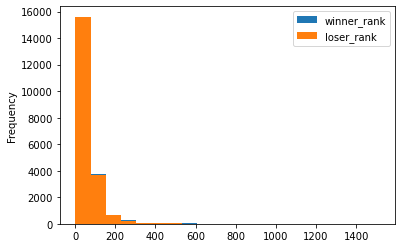

In [34]:

good_col_matches[["winner_rank", "loser_rank"]].plot.hist(bins=20)

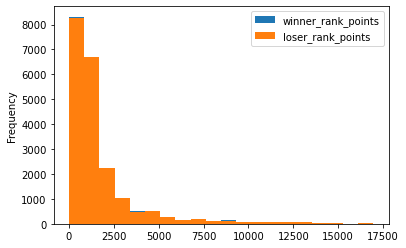

In [35]:
good_col_matches[["winner_rank_points", "loser_rank_points"]].plot.hist(bins=20)

In [36]:
#see the above plots, need to log transform

##### Transform rank and rank points columns

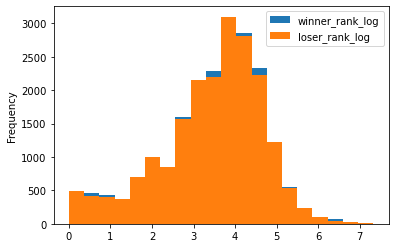

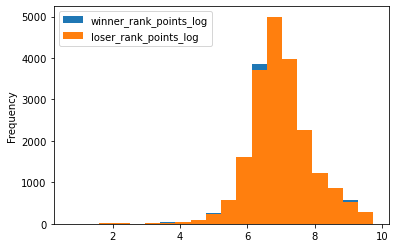

In [37]:
def rank_transform(df):
    #columns related to rankings
    rank_cols=["winner_rank", "loser_rank", "winner_rank_points", "loser_rank_points"]
    #make new names for the transformed columns
    log_rank_cols=[x+"_log" for x in rank_cols]
    #apply a log transform to the rank columns
    df[log_rank_cols]=df[rank_cols].apply(lambda x: np.log(x))
    #note: this in inplace
    return df

rank_transform(good_col_matches)
rank_transform(gcm_names)

#plot the transformed rank and rank points distributions 
good_col_matches[["winner_rank_log", "loser_rank_log"]].plot.hist(bins=20)
good_col_matches[["winner_rank_points_log", "loser_rank_points_log"]].plot.hist(bins=20)

##### Rename Columns

In [38]:
#rename relevant columns to w_{param} or l_{param} 
#instead of winner_{param} or loser_{param}
def rename_win_lose(col_name):
    #split into a list on the underscores
    splits=col_name.split("_")
    #if the first thing of the split has length 1, it is already in the right format
    if splits[0][0]=="w":
        splits.append("p1")
        final_name="_".join(splits[1:])
    elif splits[0][0]=="l":
        splits.append("p2")
        final_name="_".join(splits[1:])
    else:
        final_name="_".join(splits)
    
    return final_name

sm_2000=good_col_matches.rename(columns=rename_win_lose, inplace=False)
sm_names=gcm_names.rename(columns=rename_win_lose, inplace=False)
sm_names.loc[sm_names["name_p1"]=="Roger Federer", "ht_p1"]

21       185.0
264      185.0
556      185.0
593      185.0
612      185.0
         ...  
20276    185.0
20291    185.0
20446    185.0
20464    185.0
20482    185.0
Name: ht_p1, Length: 464, dtype: float64

### Turn stats into rolling stats

Most of this is stolen from the Method 2 section. I realized that I messed up the order of the percentage column calculation (need to sum up values before doing division rather than row wise)

##### Dictonaries to connect p1, p2 and winner loser, but same statistic

In [39]:
w_l=["w", "l"]
#get all of the statistics we have as a list
not_param_cols=other_cols+["Win","w_hand","l_hand","w_ioc","l_ioc", "w_seed", "l_seed", "total_sets", "total_games"]
params=["_".join(x.split("_")[:-1]) for x in sm_2000.columns[~sm_2000.columns.isin(not_param_cols)]]
#dictionary of form {param: [w_param, l_param]}
win_lose_dict={param:[x+"_"+param for x in w_l] for param in params}
p1_p2_dict={param: [param+"_"+x for x in ["p1", "p2"]] for param in params}
win_lose_dict.keys()

dict_keys(['1stIn', '1stWon', '2ndWon', 'SvGms', 'ace', 'bpFaced', 'bpSaved', 'df', 'svpt', 'age', 'hand', 'ht', 'ioc', 'rank', 'rank_points', 'srv_ptswon', 'ret_pts', 'ret_Gms', 'ret_won', 'bp_opp', 'bp_conv', 'SvGames_won', 'retgames_won', 'total_sets', 'total_games', 'setswon', 'gameswon', 'rank_log', 'rank_points_log'])

In [40]:
#some more helpful dictionaries
#all the parameters that are for "winner"/"loser"
#similarly all parameters for "p1"/"p2"
win_lose_param_dict={"win": ["w_"+param for param in win_lose_dict.keys()],
                     "lose": ["l_"+param for param in win_lose_dict.keys()]}

p1_p2_param_dict={"p1": [param+"_p1" for param in win_lose_dict.keys()],
                 "p2": [param+"_p2" for param in win_lose_dict.keys()]}
p1_p2_param_dict

{'p1': ['1stIn_p1',
  '1stWon_p1',
  '2ndWon_p1',
  'SvGms_p1',
  'ace_p1',
  'bpFaced_p1',
  'bpSaved_p1',
  'df_p1',
  'svpt_p1',
  'age_p1',
  'hand_p1',
  'ht_p1',
  'ioc_p1',
  'rank_p1',
  'rank_points_p1',
  'srv_ptswon_p1',
  'ret_pts_p1',
  'ret_Gms_p1',
  'ret_won_p1',
  'bp_opp_p1',
  'bp_conv_p1',
  'SvGames_won_p1',
  'retgames_won_p1',
  'total_sets_p1',
  'total_games_p1',
  'setswon_p1',
  'gameswon_p1',
  'rank_log_p1',
  'rank_points_log_p1'],
 'p2': ['1stIn_p2',
  '1stWon_p2',
  '2ndWon_p2',
  'SvGms_p2',
  'ace_p2',
  'bpFaced_p2',
  'bpSaved_p2',
  'df_p2',
  'svpt_p2',
  'age_p2',
  'hand_p2',
  'ht_p2',
  'ioc_p2',
  'rank_p2',
  'rank_points_p2',
  'srv_ptswon_p2',
  'ret_pts_p2',
  'ret_Gms_p2',
  'ret_won_p2',
  'bp_opp_p2',
  'bp_conv_p2',
  'SvGames_won_p2',
  'retgames_won_p2',
  'total_sets_p2',
  'total_games_p2',
  'setswon_p2',
  'gameswon_p2',
  'rank_log_p2',
  'rank_points_log_p2']}

In [41]:
imp_cols=list(win_lose_dict.keys())
stat_cols=[x for x in imp_cols if x not in ["hand", "ioc"]]
stat_cols

['1stIn',
 '1stWon',
 '2ndWon',
 'SvGms',
 'ace',
 'bpFaced',
 'bpSaved',
 'df',
 'svpt',
 'age',
 'ht',
 'rank',
 'rank_points',
 'srv_ptswon',
 'ret_pts',
 'ret_Gms',
 'ret_won',
 'bp_opp',
 'bp_conv',
 'SvGames_won',
 'retgames_won',
 'total_sets',
 'total_games',
 'setswon',
 'gameswon',
 'rank_log',
 'rank_points_log']

In [42]:
def player_stats(player, match_df):
    #get the past match statistics for each player in a new match
    p1_df=match_df.loc[match_df["name_p1"]==player, p1_p2_param_dict["p1"]+["hand_p2", "minutes", "surface", "tournament_date","name_p1"]]
    p1_df["pnum"]=1
    p1_ind=np.where(match_df["name_p1"]==player)
    p2_df=match_df.loc[match_df["name_p2"]==player, p1_p2_param_dict["p2"]+["hand_p1", "minutes", "surface", "tournament_date", "name_p2"]]
    p2_df["pnum"]=2
    #print("pnum 1: ", p1_df["pnum"], p2_df["pnum"])
    p2_ind=np.where(match_df["name_p2"]==player)
    #print("p1", p1_df)
    #rename a few of the columns to p1 and p2 have the same name for shared columns
    p1_df.columns=imp_cols+["opp_hand", "minutes", "surface", "Date", "name", "pnum"]
    p2_df.columns=imp_cols+["opp_hand", "minutes", "surface", "Date", "name", "pnum"]
    #print("pnum cols: ", p1_df["pnum"])
    
    #combine player 1 stats with player 2 stats
    player_df=pd.concat([p1_df, p2_df]).sort_values(by="Date")
    #print("pnum concat: ", player_df["pnum"])

    return player_df

def player_stats_avg(player, match_df, surface, window):
    player_df=player_stats(player, match_df)
    #print("pnum: ", player_df["pnum"])
    #ew=no_surface_ew_avg(player_df, span)
    #ew_surface=surface_ew_avg(player_df, span, surface)
    #ew_avg=avg_dfs(ew, ew_surface)
    #print(ew, ew_surface, ew_avg)
    #print("stats: ", stat_cols)
    ew_stats=player_df[stat_cols+["minutes"]].rolling(window=window, min_periods=int(0.2*window)).agg([np.sum])
    #print("EW post roll: ", ew_stats)
    ew_stats["name"]=player
    ew_stats[["rank_log", "rank_points_log", "pnum", "Date", "hand", "ioc", "surface", "ht", "age"]]=player_df[["rank_log", "rank_points_log", "pnum", "Date", "hand","ioc", "surface", "ht", "age"]].copy()
    #ew_stats["Date"]=player_df["Date"].copy()
    #print("ew post copy: ", ew_stats)
    #ew_s
    return ew_stats

def merge_pstats(player, match_df, surface, window, empty_df):
    ew_stats=player_stats_avg(player, match_df, surface, window).reset_index()
    #print("EW: ", ew_stats)
    ew_stats=ew_stats.reindex(sorted(ew_stats.columns), axis=1)
    
    ew_p1=ew_stats[ew_stats["pnum"]==1]
    ew_p2=ew_stats[ew_stats["pnum"]==2]
    
    #good_ew_cols=ew_stats.drop(["index", "minutes", "name", "pnum"], axis=1).columns.tolist()
    
    good_ew_cols=ew_stats.drop(["index", "minutes", "name", "pnum"], axis=1, level=0).columns.get_level_values(0)
    #print(good_ew_cols)
    
    p1_params=[c+"_p1" if c not in ["Date", "surface"] else c for c in good_ew_cols]
    p2_params=[c+"_p2" if c not in ["Date", "surface"] else c for c in good_ew_cols]
    
    return ew_p1, ew_p2, p1_params, p2_params

def apply_merging(match_df, surface, window):
    avg_df=pd.DataFrame().reindex_like(match_df)
    avg_df=avg_df.reindex(sorted(avg_df.columns), axis=1)
    players=np.unique(match_df[["name_p1", "name_p2"]].values)
    for p in players:
        ew_p1, ew_p2, p1_params, p2_params=merge_pstats(p, match_df, surface, window, avg_df)
        
        #print(p1_params)
        #print("EW p1: ", ew_p1)
        #print("EW p2: ", ew_p2)
        p1_ind=ew_p1["index"].values
        p2_ind=ew_p2["index"].values
        
        #print("p1 ind: ", p1_ind)
        #print("p2 ind: ", p2_ind)
        
        avg_df.loc[p1_ind, ["name_p1", "tournament_date", "surface"]]=ew_p1[["name", "Date", "surface"]].values
        avg_df.loc[p2_ind, ["name_p2", "tournament_date", "surface"]]=ew_p2[["name", "Date", "surface"]].values
        
    
        avg_df.loc[p1_ind, p1_params]=ew_p1.drop(["index", "minutes", "name", "pnum"], axis=1, level=0).values
        avg_df.loc[p2_ind, p2_params]=ew_p2.drop(["index", "minutes", "name", "pnum"], axis=1, level=0).values
    
    #avg_df.fillna(0, inplace=True)
    return avg_df

pd.set_option('display.max_columns', 500)
#for court in ["Hard", "Grass", "Clay"]:

print(sm_names.columns)
WINDOW=20
merged=apply_merging(sm_names, "Hard", WINDOW).drop(["ioc_p1", "ioc_p2"], axis=1)



Index(['1stIn_p1', '1stWon_p1', '2ndWon_p1', 'SvGms_p1', 'ace_p1',
       'bpFaced_p1', 'bpSaved_p1', 'df_p1', 'svpt_p1', 'age_p1', 'hand_p1',
       'ht_p1', 'ioc_p1', 'rank_p1', 'rank_points_p1', '1stIn_p2', '1stWon_p2',
       '2ndWon_p2', 'SvGms_p2', 'ace_p2', 'bpFaced_p2', 'bpSaved_p2', 'df_p2',
       'svpt_p2', 'age_p2', 'hand_p2', 'ht_p2', 'ioc_p2', 'rank_p2',
       'rank_points_p2', 'best_of', 'draw_size', 'minutes', 'round', 'score',
       'surface', 'tourney_level', 'Year', 'tournament_date', 'name_p1',
       'name_p2', 'Win', 'srv_ptswon_p1', 'srv_ptswon_p2', 'ret_pts_p1',
       'ret_pts_p2', 'ret_Gms_p1', 'ret_Gms_p2', 'ret_won_p1', 'ret_won_p2',
       'bp_opp_p1', 'bp_opp_p2', 'bp_conv_p1', 'bp_conv_p2', 'SvGames_won_p1',
       'SvGames_won_p2', 'retgames_won_p1', 'retgames_won_p2', 'total_sets_p1',
       'total_sets_p2', 'total_games_p1', 'total_games_p2', 'setswon_p1',
       'setswon_p2', 'gameswon_p1', 'gameswon_p2', 'rank_log_p1',
       'rank_log_p2', 'rank_p

In [43]:
merged

,1stIn_p1,1stIn_p2,1stWon_p1,1stWon_p2,2ndWon_p1,2ndWon_p2,SvGames_won_p1,SvGames_won_p2,SvGms_p1,SvGms_p2,Win,Year,ace_p1,ace_p2,age_p1,age_p2,best_of,bpFaced_p1,bpFaced_p2,bpSaved_p1,bpSaved_p2,bp_conv_p1,bp_conv_p2,bp_opp_p1,bp_opp_p2,df_p1,df_p2,draw_size,gameswon_p1,gameswon_p2,hand_p1,hand_p2,ht_p1,ht_p2,minutes,name_p1,name_p2,rank_log_p1,rank_log_p2,rank_p1,rank_p2,rank_points_log_p1,rank_points_log_p2,rank_points_p1,rank_points_p2,ret_Gms_p1,ret_Gms_p2,ret_pts_p1,ret_pts_p2,ret_won_p1,ret_won_p2,retgames_won_p1,retgames_won_p2,round,score,setswon_p1,setswon_p2,srv_ptswon_p1,srv_ptswon_p2,surface,svpt_p1,svpt_p2,total_games_p1,total_games_p2,total_sets_p1,total_sets_p2,tournament_date,tourney_level,Date
0,588.0,843.0,435.0,588.0,265.0,344.0,139.0,166.0,183.0,235.0,NaN,NaN,184.0,76.0,29.130732,27.890486,NaN,114.0,168.0,64.0,109.0,26.0,55.0,72.0,147.0,84.0,62.0,NaN,177.0,213.0,L,R,193.0,178.0,NaN,Goran Ivanisevic,Fabrice Santoro,4.795791,3.583519,940.0,639.0,5.758902,6.870053,7600.0,19247.0,186.0,235.0,1107.0,1538.0,358.0,597.0,35.0,44.0,NaN,NaN,20.0,20.0,700.0,932.0,Hard,1142.0,1529.0,371.0,477.0,39.0,50.0,2000-10-30,NaN,2000-10-30
1,769.0,880.0,561.0,629.0,256.0,327.0,158.0,189.0,190.0,244.0,NaN,NaN,125.0,137.0,27.148528,27.140315,NaN,117.0,134.0,80.0,76.0,40.0,54.0,123.0,131.0,72.0,74.0,NaN,210.0,252.0,L,L,193.0,188.0,NaN,Greg Rusedski,Jerome Golmard,4.488636,3.663562,583.0,1257.0,6.173786,6.827629,15463.0,13299.0,191.0,244.0,1251.0,1486.0,464.0,539.0,46.0,59.0,NaN,NaN,25.0,29.0,817.0,956.0,Hard,1288.0,1533.0,389.0,492.0,39.0,53.0,2000-10-30,NaN,2000-10-30
2,1086.0,1051.0,735.0,713.0,270.0,336.0,190.0,203.0,250.0,262.0,NaN,NaN,61.0,93.0,25.609856,25.349760,NaN,140.0,146.0,82.0,88.0,62.0,70.0,172.0,157.0,36.0,34.0,NaN,250.0,270.0,R,R,190.0,180.0,NaN,Jiri Novak,Albert Costa,3.871201,3.433987,868.0,411.0,6.665684,6.946976,16594.0,24495.0,255.0,258.0,1684.0,1622.0,656.0,622.0,57.0,66.0,NaN,NaN,22.0,26.0,1005.0,1049.0,Hard,1613.0,1665.0,517.0,531.0,53.0,55.0,2000-10-30,NaN,2000-10-30
3,500.0,1016.0,333.0,812.0,139.0,374.0,112.0,233.0,130.0,283.0,NaN,NaN,20.0,289.0,22.195756,28.900753,NaN,78.0,115.0,41.0,74.0,16.0,67.0,64.0,175.0,42.0,78.0,NaN,144.0,295.0,R,R,175.0,196.0,NaN,Alberto Martin,Richard Krajicek,4.418841,3.610918,677.0,610.0,6.240276,6.836259,6120.0,20121.0,129.0,286.0,843.0,1841.0,280.0,683.0,31.0,58.0,NaN,NaN,18.0,32.0,472.0,1186.0,Hard,770.0,1737.0,265.0,577.0,28.0,58.0,2000-10-30,NaN,2000-10-30
4,727.0,1009.0,494.0,766.0,274.0,344.0,135.0,218.0,195.0,274.0,NaN,NaN,56.0,217.0,24.514716,29.979466,NaN,127.0,134.0,77.0,84.0,50.0,52.0,114.0,165.0,52.0,131.0,NaN,178.0,270.0,R,R,180.0,201.0,NaN,Rainer Schuettler,Marc Rosset,4.025352,3.332205,909.0,698.0,6.549651,6.975414,7730.0,17094.0,193.0,276.0,1228.0,1812.0,476.0,647.0,42.0,47.0,NaN,NaN,12.0,25.0,768.0,1110.0,Hard,1262.0,1717.0,393.0,559.0,40.0,56.0,2000-10-30,NaN,2000-10-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20479,1440.0,1325.0,1061.0,1006.0,421.0,375.0,308.0,259.0,365.0,327.0,NaN,NaN,221.0,206.0,28.498289,38.450376,NaN,179.0,127.0,110.0,86.0,59.0,86.0,157.0,186.0,71.0,44.0,NaN,374.0,317.0,R,R,188.0,185.0,NaN,Tennys Sandgren,Roger Federer,4.605170,1.098612,1599.0,60.0,6.350886,8.793309,14713.0,137080.0,358.0,328.0,2276.0,2066.0,769.0,813.0,67.0,63.0,NaN,NaN,37.0,37.0,1482.0,1381.0,Hard,2311.0,2015.0,734.0,635.0,74.0,68.0,2020-01-20,NaN,2020-01-20
20480,1088.0,1038.0,897.0,837.0,371.0,291.0,267.0,222.0,294.0,270.0,NaN,NaN,382.0,149.0,29.065024,32.665298,NaN,83.0,73.0,67.0,48.0,48.0,65.0,140.0,144.0,77.0,67.0,NaN,309.0,260.0,R,R,196.0,188.0,NaN,Milos Raonic,Novak Djokovic,3.555348,0.693147,444.0,24.0,7.173958,9.181941,36265.0,214470.0,290.0,265.0,1823.0,1704.0,639.0,676.0,38.0,47.0,NaN,NaN,33.0,28.0,1268.0,1128.0,Hard,1730

In [44]:
merged[(merged["name_p1"]=="Roger Federer")|(merged["name_p2"]=="Roger Federer")]

,1stIn_p1,1stIn_p2,1stWon_p1,1stWon_p2,2ndWon_p1,2ndWon_p2,SvGames_won_p1,SvGames_won_p2,SvGms_p1,SvGms_p2,Win,Year,ace_p1,ace_p2,age_p1,age_p2,best_of,bpFaced_p1,bpFaced_p2,bpSaved_p1,bpSaved_p2,bp_conv_p1,bp_conv_p2,bp_opp_p1,bp_opp_p2,df_p1,df_p2,draw_size,gameswon_p1,gameswon_p2,hand_p1,hand_p2,ht_p1,ht_p2,minutes,name_p1,name_p2,rank_log_p1,rank_log_p2,rank_p1,rank_p2,rank_points_log_p1,rank_points_log_p2,rank_points_p1,rank_points_p2,ret_Gms_p1,ret_Gms_p2,ret_pts_p1,ret_pts_p2,ret_won_p1,ret_won_p2,retgames_won_p1,retgames_won_p2,round,score,setswon_p1,setswon_p2,srv_ptswon_p1,srv_ptswon_p2,surface,svpt_p1,svpt_p2,total_games_p1,total_games_p2,total_sets_p1,total_sets_p2,tournament_date,tourney_level,Date
21,1083.0,1243.0,778.0,881.0,395.0,429.0,220.0,240.0,270.0,332.0,NaN,NaN,159.0,104.0,19.227926,26.696783,NaN,156.0,218.0,103.0,139.0,48.0,81.0,136.0,201.0,77.0,122.0,NaN,281.0,317.0,R,R,185.0,190.0,NaN,Roger Federer,Yevgeny Kafelnikov,3.218876,1.609438,875.0,96.0,7.016610,7.951911,14166.0,56355.0,267.0,330.0,1783.0,2147.0,645.0,827.0,51.0,73.0,NaN,NaN,31.0,27.0,1173.0,1310.0,Hard,1862.0,2155.0,551.0,666.0,53.0,66.0,2000-10-30,NaN,2000-10-30
49,NaN,210.0,NaN,146.0,NaN,88.0,NaN,42.0,NaN,54.0,NaN,NaN,NaN,37.0,23.145791,18.614648,NaN,NaN,27.0,NaN,18.0,NaN,11.0,NaN,31.0,NaN,18.0,NaN,NaN,54.0,R,R,196.0,185.0,NaN,Justin Gimelstob,Roger Federer,4.595120,3.970292,NaN,239.0,6.045005,6.624065,NaN,2613.0,NaN,55.0,NaN,369.0,NaN,143.0,NaN,9.0,NaN,NaN,NaN,6.0,NaN,234.0,Hard,NaN,362.0,NaN,110.0,NaN,11.0,2000-03-20,NaN,2000-03-20
80,292.0,255.0,234.0,180.0,172.0,103.0,72.0,52.0,99.0,65.0,NaN,NaN,56.0,42.0,22.056126,18.614648,NaN,52.0,29.0,32.0,19.0,22.0,11.0,59.0,31.0,36.0,21.0,NaN,90.0,64.0,R,R,183.0,185.0,NaN,Mariano Zabaleta,Roger Federer,3.218876,3.970292,208.0,292.0,7.005789,6.624065,6998.0,3366.0,99.0,66.0,650.0,432.0,251.0,156.0,17.0,9.0,NaN,NaN,6.0,6.0,406.0,283.0,Hard,641.0,438.0,201.0,133.0,19.0,13.0,2000-03-20,NaN,2000-03-20
224,416.0,313.0,284.0,215.0,111.0,123.0,75.0,61.0,98.0,79.0,NaN,NaN,40.0,46.0,25.073238,18.691307,NaN,48.0,48.0,26.0,33.0,27.0,14.0,70.0,37.0,12.0,28.0,NaN,102.0,76.0,R,R,190.0,185.0,NaN,Jiri Novak,Roger Federer,3.610918,3.891820,278.0,341.0,6.759255,6.642487,5938.0,4133.0,100.0,79.0,664.0,510.0,269.0,185.0,25.0,12.0,NaN,NaN,11.0,7.0,395.0,338.0,Clay,638.0,543.0,202.0,160.0,21.0,16.0,2000-04-17,NaN,2000-04-17
264,397.0,568.0,275.0,349.0,155.0,109.0,82.0,76.0,104.0,119.0,NaN,NaN,55.0,28.0,18.767967,26.297057,NaN,56.0,80.0,35.0,42.0,16.0,46.0,51.0,86.0,34.0,12.0,NaN,102.0,119.0,R,R,185.0,183.0,NaN,Roger Federer,Andrei Pavel,3.912023,4.248495,442.0,800.0,6.599870,6.359574,5600.0,6310.0,104.0,118.0,666.0,769.0,234.0,343.0,17.0,40.0,NaN,NaN,10.0,12.0,430.0,458.0,Clay,691.0,791.0,209.0,241.0,21.0,25.0,2000-05-15,NaN,2000-05-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20446,1271.0,1318.0,973.0,902.0,359.0,343.0,259.0,245.0,318.0,318.0,NaN,NaN,215.0,117.0,38.450376,27.895962,NaN,113.0,187.0,76.0,107.0,85.0,74.0,178.0,179.0,43.0,34.0,NaN,319.0,328.0,R,R,185.0,185.0,NaN,Roger Federer,Filip Krajinovic,1.098612,3.713572,60.0,1535.0,8.793309,7.054450,137140.0,15854.0,318.0,315.0,2012.0,2071.0,798.0,786.0,65.0,80.0,NaN,NaN,38.0,32.0,1332.0,1245.0,Hard,1918.0,2004.0,617.0,644.0,66.0,64.0,2020-01-20,NaN,2020-01-20
20464,1294.0,1241.0,1000.0,834.0,390.0,412.0,269.0,227.0,329.0,300.0,NaN,NaN,200.0,101.0,38.450376,30.600958,NaN,105.0,187.0,70.0,114.0,84.0,62.0,187.0,145.0,43.0,48.0,NaN,325.0,293.0,R,R,185.0,183.0,NaN,Roger Federer,John Millman,1.098612,3.850148,60.0,1042.0,8.793309,6.999422,136530.0,19694.0,329.0,300.0,2103.0,1920.0,832.0,702.0,62.0,64.0,NaN,NaN,36.0,24.0,1390.0,1246.0,Hard,1973.0,2028.0,639.0,610.0,68.0,62.0,2020-01-20,NaN,2020-01-20
20474,1144.0,1255.0,771.0,963.0,407.0,

In [45]:
sm_names[(sm_names["name_p1"]=="Roger Federer")|(sm_names["name_p2"]=="Roger Federer")]

,1stIn_p1,1stWon_p1,2ndWon_p1,SvGms_p1,ace_p1,bpFaced_p1,bpSaved_p1,df_p1,svpt_p1,age_p1,hand_p1,ht_p1,ioc_p1,rank_p1,rank_points_p1,1stIn_p2,1stWon_p2,2ndWon_p2,SvGms_p2,ace_p2,bpFaced_p2,bpSaved_p2,df_p2,svpt_p2,age_p2,hand_p2,ht_p2,ioc_p2,rank_p2,rank_points_p2,best_of,draw_size,minutes,round,score,surface,tourney_level,Year,tournament_date,name_p1,name_p2,Win,srv_ptswon_p1,srv_ptswon_p2,ret_pts_p1,ret_pts_p2,ret_Gms_p1,ret_Gms_p2,ret_won_p1,ret_won_p2,bp_opp_p1,bp_opp_p2,bp_conv_p1,bp_conv_p2,SvGames_won_p1,SvGames_won_p2,retgames_won_p1,retgames_won_p2,total_sets_p1,total_sets_p2,total_games_p1,total_games_p2,setswon_p1,setswon_p2,gameswon_p1,gameswon_p2,rank_log_p1,rank_log_p2,rank_points_log_p1,rank_points_log_p2
21,46.0,30.0,14.0,10.0,7.0,9.0,5.0,5.0,79.0,19.227926,R,185.0,SUI,25.0,1115.0,21.0,16.0,25.0,11.0,3.0,5.0,3.0,5.0,61.0,26.696783,R,190.0,RUS,5.0,2841.0,3,48,73.0,R32,7-5 6-3,Hard,M,2000,2000-10-30,Roger Federer,Yevgeny Kafelnikov,0,44.0,41.0,61.0,79.0,10.0,11.0,20.0,35.0,5.0,9.0,2.0,4.0,9.0,6.0,4.0,2.0,2,2,21,21,2,0,13,8,3.218876,1.609438,7.016610,7.951911
49,41.0,27.0,11.0,10.0,2.0,6.0,4.0,5.0,60.0,23.145791,R,196.0,USA,99.0,422.0,42.0,29.0,19.0,11.0,7.0,2.0,2.0,1.0,67.0,18.614648,R,185.0,SUI,53.0,753.0,3,96,73.0,R128,7-5 6-3,Hard,M,2000,2000-03-20,Justin Gimelstob,Roger Federer,0,38.0,48.0,67.0,60.0,10.0,11.0,19.0,22.0,2.0,6.0,0.0,2.0,11.0,8.0,2.0,0.0,2,2,21,21,2,0,13,8,4.595120,3.970292,6.045005,6.624065
80,32.0,27.0,23.0,11.0,3.0,0.0,0.0,1.0,63.0,22.056126,R,183.0,ARG,25.0,1103.0,45.0,34.0,15.0,11.0,5.0,2.0,1.0,3.0,76.0,18.614648,R,185.0,SUI,53.0,753.0,3,96,87.0,R64,6-4 7-6(7),Hard,M,2000,2000-03-20,Mariano Zabaleta,Roger Federer,1,50.0,49.0,76.0,63.0,11.0,11.0,27.0,13.0,2.0,0.0,1.0,0.0,11.0,10.0,1.0,0.0,2,2,23,23,2,0,13,10,3.218876,3.970292,7.005789,6.624065
224,59.0,39.0,10.0,13.0,2.0,6.0,3.0,0.0,78.0,25.073238,R,190.0,CZE,37.0,862.0,58.0,35.0,20.0,14.0,4.0,19.0,14.0,7.0,105.0,18.691307,R,185.0,SUI,49.0,767.0,3,64,106.0,R64,6-1 2-6 7-5,Clay,M,2000,2000-04-17,Jiri Novak,Roger Federer,1,49.0,55.0,105.0,78.0,14.0,13.0,50.0,29.0,19.0,6.0,5.0,3.0,10.0,9.0,5.0,3.0,3,3,27,27,2,1,15,12,3.610918,3.891820,6.759255,6.642487
264,37.0,24.0,10.0,10.0,4.0,4.0,0.0,2.0,60.0,18.767967,R,185.0,SUI,50.0,735.0,37.0,28.0,7.0,9.0,2.0,1.0,0.0,1.0,46.0,26.297057,R,183.0,ROU,70.0,578.0,3,64,61.0,R64,6-4 6-3,Clay,M,2000,2000-05-15,Roger Federer,Andrei Pavel,0,34.0,35.0,46.0,60.0,10.0,9.0,11.0,26.0,1.0,4.0,1.0,4.0,8.0,6.0,4.0,1.0,2,2,19,19,2,0,12,7,3.912023,4.248495,6.599870,6.359574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20446,47.0,36.0,13.0,12.0,14.0,3.0,2.0,0.0,68.0,38.450376,R,185.0,SUI,3.0,6590.0,57.0,33.0,4.0,12.0,4.0,14.0,7.0,2.0,77.0,27.895962,R,185.0,SRB,41.0,1158.0,5,128,92.0,R64,6-1 6-4 6-1,Hard,G,2020,2020-01-20,Roger Federer,Filip Krajinovic,1,49.0,37.0,77.0,68.0,12.0,12.0,40.0,19.0,14.0,3.0,7.0,1.0,11.0,5.0,7.0,1.0,3,3,24,24,3,0,18,6,1.098612,3.713572,8.793309,7.054450
20464,111.0,85.0,30.0,27.0,16.0,8.0,4.0,6.0,170.0,38.450376,R,185.0,SUI,3.0,6590.0,118.0,80.0,43.0,27.0,11.0,10.0,7.0,4.0,189.0,30.600958,R,183.0,AUS,47.0,1096.0,5,128,243.0,R32,4-6 7-6(2) 6-4 4-6 7-6(8),Hard,G,2020,2020-01-20,Roger Federer,John Millman,1,115.0,123.0,189.0,170.0,27.0,27.0,66.0,55.0,10.0,8.0,3.0,4.0,23.0,24.0,3.0,4.0,5,5,56,56,3,2,28,28,1.098612,3.850148,8.793309,6.999422
20474,42.0,24.0,25.0,16.0,1.0,12.0,5.0,1.0,89.0,27.947981,R,188.0,HUN,67.0,827.0,63.0,48.0,21.0,17.0,5.0,9.0,7.0,0.0,103.0,38.450376,R,185.0,SUI,3.0,6590.0,5,128,131.0,R16,4-6 6-1 6-2 6-2,Hard,G,2020,2020-01-20,Marton Fucsovics,Roger Federer,0,49.0,69.0,103.0,89.0,16.0,17.0,34.0,40.0,9.0,12.0,2.0,7.0,15.0,9.0,7.0,2.0,4,4,33,33,3,1,22,11,4.204693,1.098612,6.717805,8.793309
20479,97.0,77.0,24.0,23.0,27.0,13.0,11.0,5.0,150.0,28.49828

### Percentage columns

In [49]:

def expected_win(matches_df):
    #P(win on first serve)+P(win on second serve)-P(double fault)
    #NOTE: aces are included in P(win on first serve)
    for side in ["p1", "p2"]:
        matches_df[f"expected_srvwin_{side}"]=matches_df[f"1stsrv_perc_{side}"]*matches_df[f"1stwin_perc_{side}"]\
            +(1-matches_df[f"1stsrv_perc_{side}"])*matches_df[f"2ndsrv_perc_{side}"]*matches_df[f"2ndwin_perc_{side}"]\
            -matches_df[f"df_perc_{side}"]
    #P(server loses on first serve)+P(server loses on second serve)+P(double fault)
    for side1, side2 in zip(["p1", "p2"], ["p2", "p1"]): 
        matches_df[f"expected_retwin_{side1}"]=1-matches_df[f"expected_srvwin_{side2}"]
    #    matches_df[f"expected_retwin_{side1}"]=matches_df[f"1stsrv_perc_{side2}"]*(1-matches_df[f"1stwin_perc_{side2}"])\
    #        +(1-matches_df[f"1stsrv_perc_{side2}"])*matches_df[f"2ndsrv_perc_{side2}"]*(1-matches_df[f"2ndwin_perc_{side2}"])\
    #        +matches_df[f"df_perc_{side2}"]
        
    return matches_df

In [50]:
#CHECK THE 2nd SERVE STUFF PRETTY SURE THE PERCENTAGES ARE WRONG
def percentage_calculations(matches_df):
    for side in ["p1", "p2"]:
        #percent of serve points that were won
        matches_df[f"srvwon_perc_{side}"]=matches_df[f"srv_ptswon_{side}"]/matches_df[f"svpt_{side}"]
        #percent of return points won
        matches_df[f"retwon_perc_{side}"]=matches_df[f"ret_won_{side}"]/matches_df[f"ret_pts_{side}"]
        #number of second serves that went in
        matches_df[f"2ndIn_{side}"]=matches_df[f"svpt_{side}"]-matches_df[f"1stIn_{side}"]-matches_df[f"df_{side}"]
        #percent of break points faced that were saved
        matches_df[f"bp_save_perc_{side}"]=matches_df[f"bpSaved_{side}"]/matches_df[f"bpFaced_{side}"]
        #percent of break points that were converted as a returner
        matches_df[f"bp_conv_perc_{side}"]=matches_df[f"bp_conv_{side}"]/matches_df[f"bp_opp_{side}"]
        #percent of serve points that were aces
        matches_df[f"ace_perc_{side}"]=matches_df[f"ace_{side}"]/matches_df[f"svpt_{side}"]
        #percent of serve points that were double faults
        matches_df[f"df_perc_{side}"]=matches_df[f"df_{side}"]/matches_df[f"svpt_{side}"]
        #bp opp/ret game, ie bp creation rate
        matches_df[f"bp_per_retgame_{side}"]=matches_df[f"bp_opp_{side}"]/matches_df[f"ret_Gms_{side}"]
        #bp faced/sv game, ie bp faced rate
        matches_df[f"bp_per_svgame_{side}"]=matches_df[f"bpFaced_{side}"]/matches_df[f"SvGms_{side}"]
        #percent of serves in for each serve
        matches_df[f"1stsrv_perc_{side}"]=matches_df[f"1stIn_{side}"]/matches_df[f"svpt_{side}"]
        matches_df[f"2ndsrv_perc_{side}"]=matches_df[f"2ndIn_{side}"]/(matches_df[f"svpt_{side}"]-matches_df[f"1stIn_{side}"])
        #games won percentage
        matches_df[f"gameswon_perc_{side}"]=matches_df[f"gameswon_{side}"]/matches_df[f"total_games_{side}"]
        #sets won percentage
        matches_df[f"setswon_perc_{side}"]=matches_df[f"setswon_{side}"]/matches_df[f"total_sets_{side}"]
        #svgames won perc
        matches_df[f"srvgames_won_perc_{side}"]=matches_df[f"SvGames_won_{side}"]/matches_df[f"SvGms_{side}"]
        #return games won perc
        matches_df[f"retgames_won_perc_{side}"]=matches_df[f"retgames_won_{side}"]/matches_df[f"ret_Gms_{side}"]
        for servenum in ["1st", "2nd"]:
            
            #when you make a serve, what percent did you win for each serve
            matches_df[f"{servenum}win_perc_{side}"]=matches_df[f"{servenum}Won_{side}"]/matches_df[f"{servenum}In_{side}"]
        #1st srv win%/2nd serve win %
        matches_df[f"1steff_{side}"]=matches_df[f"1stwin_perc_{side}"]/matches_df[f"2ndwin_perc_{side}"]   
            
        
    expected_win(matches_df)  
    return matches_df
sm_2000=percentage_calculations(merged)
sm_2000_noroll=percentage_calculations(sm_names)

sm_2000

sm_2000.to_csv(os.path.join(PATH, "sm_2000.csv"), index=False)



In [51]:
def drop_non_perc(df):
    perc_list=["srvwon_perc", "retwon_perc", 
        "bp_save_perc", "bp_conv_perc",
        "ace_perc", "df_perc",
        "bp_per_retgame", "bp_per_svgame",
        "1stsrv_perc", "2ndsrv_perc",
        "1stwin_perc", "2ndwin_perc",
        "gameswon_perc", "setswon_perc",
        "srvgames_won_perc", "retgames_won_perc",
        "1steff",
        "expected_srvwin", "expected_retwin"]
    
    other_p1p2_cols=["name", "rank_log", "rank_points_log", "ht", "age"]
    
    no_p1p2_cols=["surface", "Date"]
   
    #either use the above lists
    try:
        #make perc_list and other_p1p2_cols have suffixes
        perc_cols=[c+side for c in perc_list+other_p1p2_cols for side in ["_p1", "_p2"]]
        #only the percentage columns
        df_perc=df[perc_cols+no_p1p2_cols]
    #or edit the lists
    except:
        #don't include name but include everything else
        other_p1p2_cols=[o for o in other_p1p2_cols if o!="name"]
        #add suffixes
        perc_cols=[c+side for c in perc_list+other_p1p2_cols for side in ["_p1", "_p2"]]
        #only percentage columns, no columns that are same for both players
        df_perc=df[perc_cols]
    return df_perc

sm_perc=drop_non_perc(sm_2000)
sm_perc_noroll=drop_non_perc(sm_2000_noroll)
sm_perc["Win"]=sm_names["Win"].copy()
sm_perc_noroll["Win"]=sm_names["Win"].copy()
#replace rank nans with 999
sm_perc[["rank_points_log_p1", "rank_points_log_p2", "rank_log_p1", "rank_log_p2"]]=sm_perc[["rank_points_log_p1", "rank_points_log_p2", "rank_log_p1", "rank_log_p2"]].fillna(999)
sm_perc_noroll[["rank_points_log_p1", "rank_points_log_p2", "rank_log_p1", "rank_log_p2"]]=sm_perc_noroll[["rank_points_log_p1", "rank_points_log_p2", "rank_log_p1", "rank_log_p2"]].fillna(999)
#replace other nans with 0 (things like percentages being nan means division by 0 eg no bp opportunities, so 0 makes sense)



print("roll: ", sm_perc.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))
print("no roll: ", sm_perc_noroll.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))

#print(sm_perc.index[np.isinf(sm_perc).any(1)])
#print(sm_perc.columns.to_series()[np.isinf(sm_perc).any()])

#print(sm_perc_noroll.index[np.isinf(sm_perc_noroll).any(1)])
#print(sm_perc_noroll.columns.to_series()[np.isinf(sm_perc_noroll).any()])

with pd.option_context('mode.use_inf_as_na', True):
    sm_perc.fillna(0, inplace=True)
    sm_perc_noroll.fillna(0, inplace=True)
#sm_perc.replace([-np.inf, np.inf], np.nan)
#sm_perc_noroll.replace([-np.inf, np.inf], np.nan)
#sm_perc.fillna(0, inplace=True)
#sm_perc_noroll.fillna(0, inplace=True)


print("roll: ", sm_perc.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))
print("no roll: ", sm_perc_noroll.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))

C:\Users\andyk\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andyk\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andyk\Anaconda3\lib\site-packages\pandas\core\frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

roll:  srvwon_perc_p1          0.0
srvwon_perc_p2          0.0
retwon_perc_p1          0.0
retwon_perc_p2          0.0
bp_save_perc_p1         0.0
bp_save_perc_p2         0.0
bp_conv_perc_p1         0.0
bp_conv_perc_p2         0.0
ace_perc_p1             0.0
ace_perc_p2             0.0
df_perc_p1              0.0
df_perc_p2              0.0
bp_per_retgame_p1       0.0
bp_per_retgame_p2       0.0
bp_per_svgame_p1        0.0
bp_per_svgame_p2        0.0
1stsrv_perc_p1          0.0
1stsrv_perc_p2          0.0
2ndsrv_perc_p1          0.0
2ndsrv_perc_p2          0.0
1stwin_perc_p1          0.0
1stwin_perc_p2          0.0
2ndwin_perc_p1          0.0
2ndwin_perc_p2          0.0
gameswon_perc_p1        0.0
gameswon_perc_p2        0.0
setswon_perc_p1         0.0
setswon_perc_p2         0.0
srvgames_won_perc_p1    0.0
srvgames_won_perc_p2    0.0
retgames_won_perc_p1    0.0
retgames_won_perc_p2    0.0
1steff_p1               0.0
1steff_p2               0.0
expected_srvwin_p1      0.0
expected_srvw

In [52]:
[col for col in list(sm_perc.columns) if col not in list(sm_perc_noroll.columns)]

['name_p1', 'name_p2', 'surface', 'Date']

In [ ]:
window_range=range(5,105, 5)
mse_df=pd.DataFrame(index=window_range, columns=sm_perc.columns.tolist())
wind_sm_percs={}
for window in window_range:
    #kf = KFold(n_splits=2)
    #kf.get_n_splits(X)
    #KFold(n_splits=5, random_state=None, shuffle=False)
    #for train_index, test_index in kf.split(X):
    #    print("TRAIN:", train_index, "TEST:", test_index)
    #    X_train, X_test = sm_names[train_index], sm_names[test_index]
    #    y_train, y_test = sm_perc_noroll[train_index], sm_perc_noroll[test_index]
    print("window: ", window)
    start=time.time()
    wind_merged=apply_merging(sm_names, "Hard", window).drop(["ioc_p1", "ioc_p2"], axis=1)
    merge_time=time.time()
    print("done with merge: ", merge_time-start)
    wind_sm_2000=percentage_calculations(wind_merged)
    wind_sm_perc=drop_non_perc(wind_sm_2000)
    
    print("done with perc: ", time.time()-merge_time)
    wind_sm_perc["Win"]=sm_names["Win"].copy()
    #replace rank nans with 999
    wind_sm_perc[["rank_points_log_p1", "rank_points_log_p2", "rank_log_p1", "rank_log_p2"]]=wind_sm_perc[["rank_points_log_p1", "rank_points_log_p2", "rank_log_p1", "rank_log_p2"]].fillna(999)
    #replace other nans with 0 (things like percentages being nan means division by 0 eg no bp opportunities, so 0 makes sense)
    wind_sm_perc.fillna(0, inplace=True)
    
    mse_time=time.time()
    print("starting mse" )
    for col in sm_perc_noroll.columns.tolist():
        #print("col: ", col)
        #print("no roll: ", *sm_perc_noroll[col].values)
        #print("roll: ", wind_sm_perc[col])
        #print("no roll nan: ", sm_perc_noroll[col].isnull().sum())
        mse_df.loc[window, col]=mean_squared_error(wind_sm_perc[col], sm_perc_noroll[col])
    print("done with mse: ", time.time()-mse_time)
    wind_sm_percs[window]=wind_sm_perc
    wind_sm_perc.to_csv(os.path.join(PATH, f"sm_perc_{window}.csv"), index=False)
mse_df

In [ ]:
mse_df.to_csv(os.path.join(PATH, "mse_df.csv"), index=False)

In [ ]:
#wind_sm_percs

In [ ]:
sm_names.to_csv(os.path.join(PATH, "sm_names.csv"), index=False)
sm_perc.to_csv(os.path.join(PATH, "sm_perc.csv"), index=False)

In [ ]:
#hand feature engineering
#sm_2000["hands"]=sm_2000["hand_p1"]+sm_2000["hand_p2"]
#sm_2000["hands"]

In [ ]:
sm_2000.shape

### Percentages over time

In [53]:
#took these from the drop_non_perc fcn
other_p1p2_cols=["name", "rank_log", "rank_points_log", "ht", "age"]
no_p1p2_cols=["surface", "Date", "Win"]
no_plot=[o+side for o in other_p1p2_cols for side in ["_p1", "_p2"]]+no_p1p2_cols
plot_cols=[col for col in sm_perc.columns.tolist() if col not in no_plot]
print("pc: ", plot_cols)
p1_plot_cols=[pc for pc in plot_cols if pc.endswith("p1")]
p2_plot_cols=[pc for pc in plot_cols if pc.endswith("p2")]
imp_plot_cols=["_".join(x.split("_")[:-1]) for x in p1_plot_cols]
print(p1_plot_cols)
print(imp_plot_cols)

pc:  ['srvwon_perc_p1', 'srvwon_perc_p2', 'retwon_perc_p1', 'retwon_perc_p2', 'bp_save_perc_p1', 'bp_save_perc_p2', 'bp_conv_perc_p1', 'bp_conv_perc_p2', 'ace_perc_p1', 'ace_perc_p2', 'df_perc_p1', 'df_perc_p2', 'bp_per_retgame_p1', 'bp_per_retgame_p2', 'bp_per_svgame_p1', 'bp_per_svgame_p2', '1stsrv_perc_p1', '1stsrv_perc_p2', '2ndsrv_perc_p1', '2ndsrv_perc_p2', '1stwin_perc_p1', '1stwin_perc_p2', '2ndwin_perc_p1', '2ndwin_perc_p2', 'gameswon_perc_p1', 'gameswon_perc_p2', 'setswon_perc_p1', 'setswon_perc_p2', 'srvgames_won_perc_p1', 'srvgames_won_perc_p2', 'retgames_won_perc_p1', 'retgames_won_perc_p2', '1steff_p1', '1steff_p2', 'expected_srvwin_p1', 'expected_srvwin_p2', 'expected_retwin_p1', 'expected_retwin_p2']
['srvwon_perc_p1', 'retwon_perc_p1', 'bp_save_perc_p1', 'bp_conv_perc_p1', 'ace_perc_p1', 'df_perc_p1', 'bp_per_retgame_p1', 'bp_per_svgame_p1', '1stsrv_perc_p1', '2ndsrv_perc_p1', '1stwin_perc_p1', '2ndwin_perc_p1', 'gameswon_perc_p1', 'setswon_perc_p1', 'srvgames_won_perc

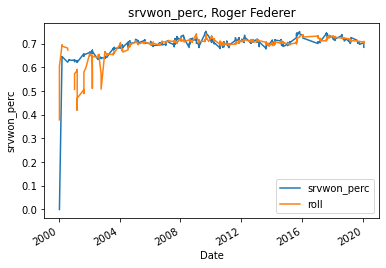

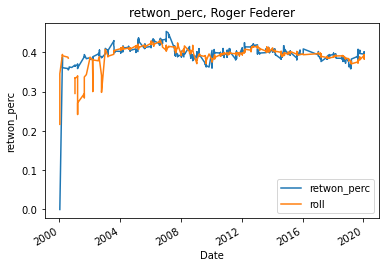

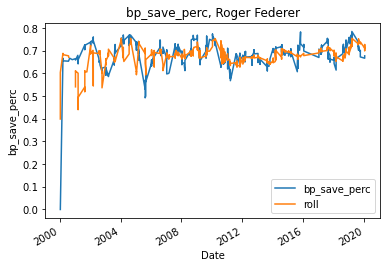

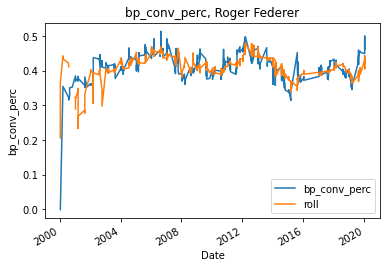

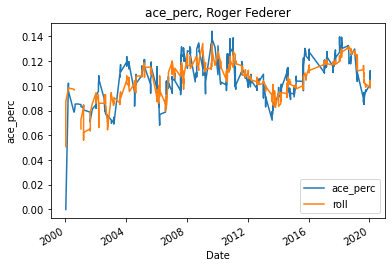

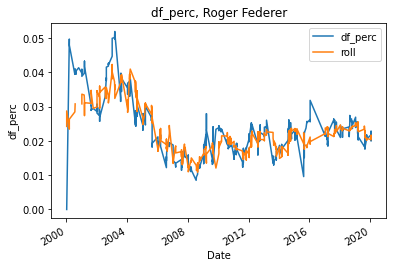

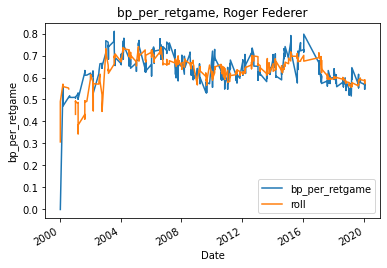

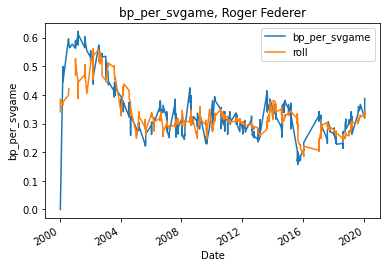

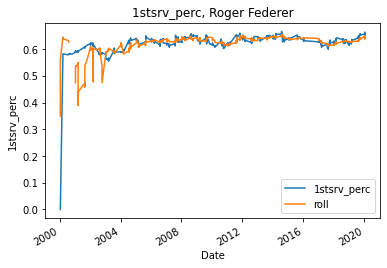

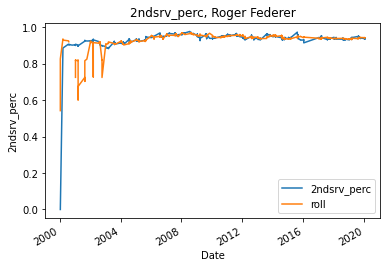

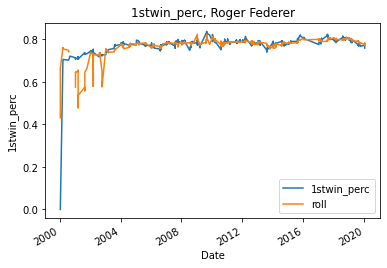

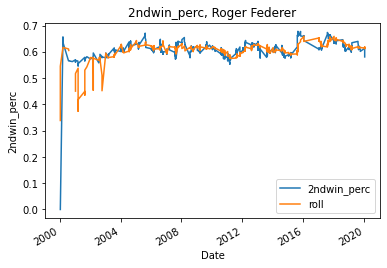

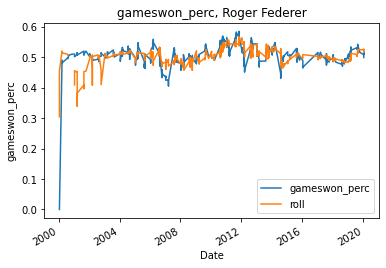

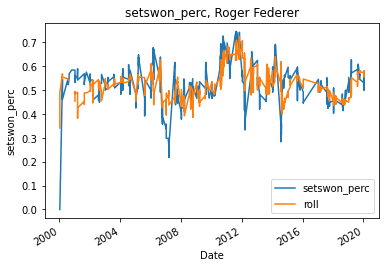

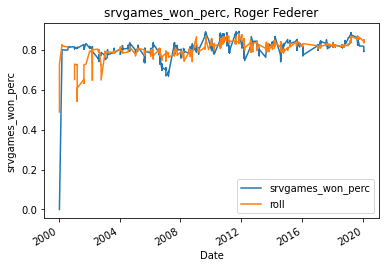

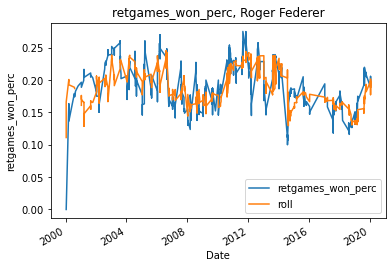

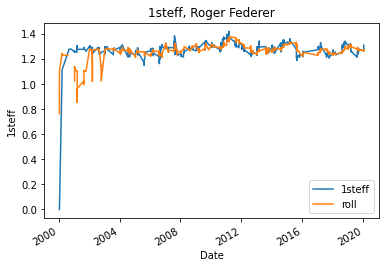

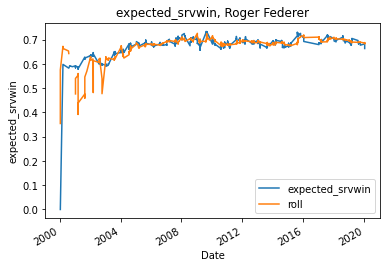

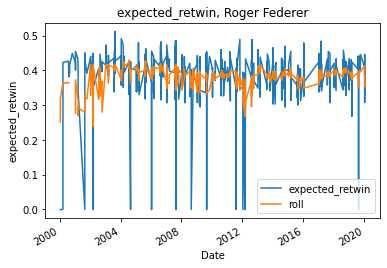

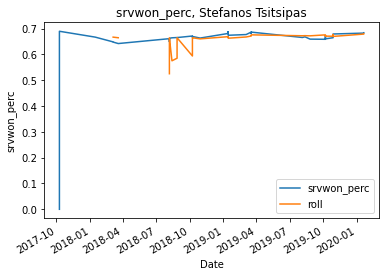

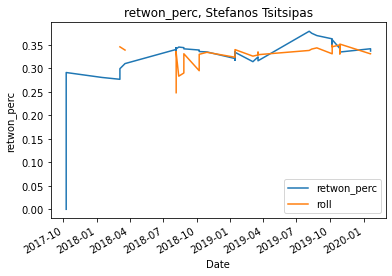

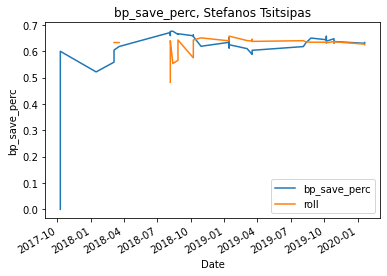

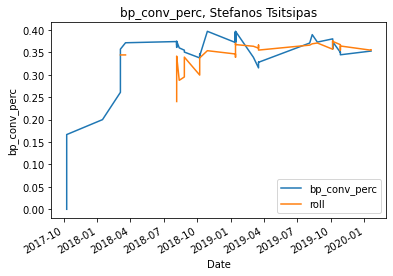

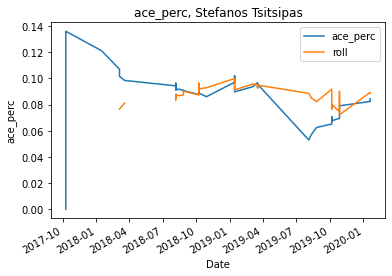

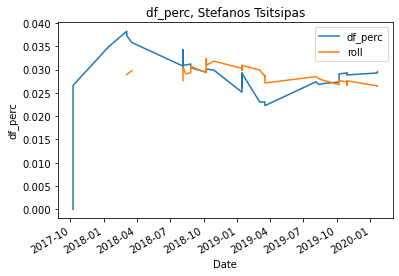

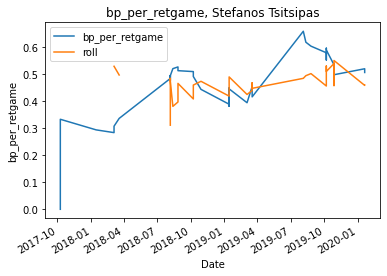

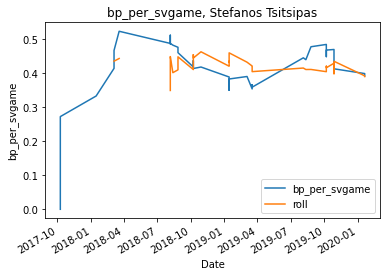

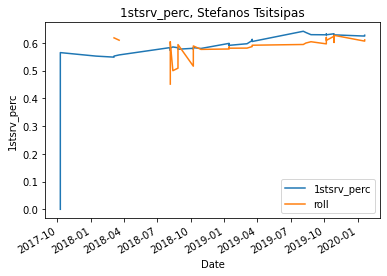

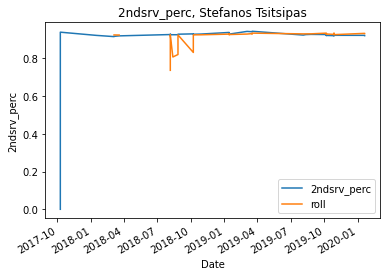

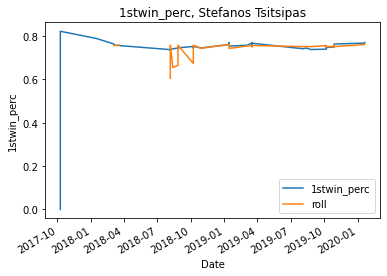

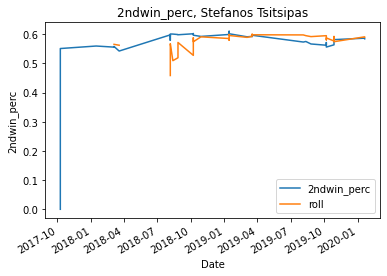

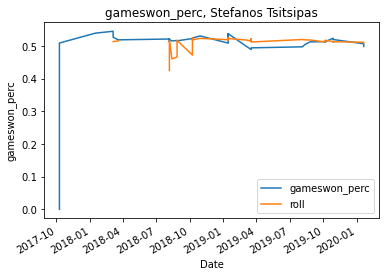

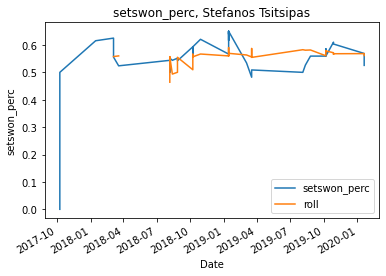

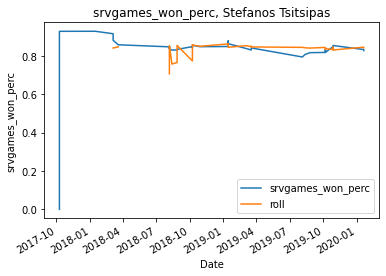

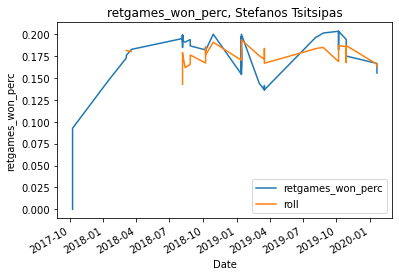

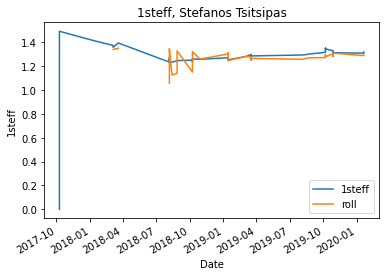

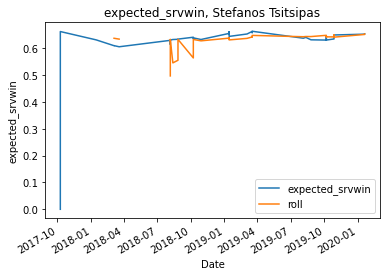

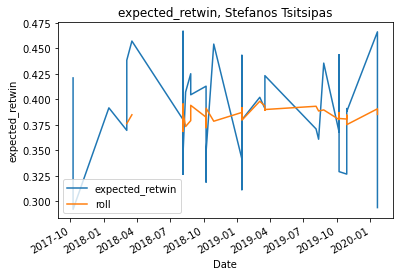

In [54]:
plot_players=["Roger Federer", "Stefanos Tsitsipas"]
player_dict={}
for player in plot_players:
    p1_df=sm_perc.loc[sm_perc["name_p1"]==player, p1_plot_cols+["Date", "surface"]]
    p1_df["pnum"]=1
    p1_ind=np.where(sm_perc["name_p1"]==player)
    p2_df=sm_perc.loc[sm_perc["name_p2"]==player, p2_plot_cols+["Date", "surface"]]
    p2_df["pnum"]=2
    #print("pnum 1: ", p1_df["pnum"], p2_df["pnum"])
    p2_ind=np.where(sm_perc["name_p2"]==player)
    #print("p1", p1_df)
    #rename a few of the columns to p1 and p2 have the same name for shared columns
    #print("imp: ", imp_plot_cols+["Date"])
    #print("p1: ", p1_df.columns.tolist())
    p1_df.columns=imp_plot_cols+["Date", "surface", "pnum"]
    p2_df.columns=imp_plot_cols+["Date", "surface", "pnum"]
    #print("pnum cols: ", p1_df["pnum"])
    
    #combine player 1 stats with player 2 stats
    player_df=pd.concat([p1_df, p2_df])
    
    
    #print("Date 1: ", player_df.Date)
    player_df["Date"]=pd.to_datetime(player_df["Date"], format="%Y-%m-%d")
    #print("Date 2: ", player_df.Date)
    #player_df=player_df[(player_df["Date"].dt.year<=2019)&(player_df["Date"].dt.year>2017)]
    #player_df.sort_values(by="Date", inplace=True)
    #player_df.set_index(["Date"], inplace=True)
    
    #p_df["surface"]=player_df["surface"].values
    #print(player_df.head())
    
    player_dict[player]=player_df
    
    
    for col in imp_plot_cols:
        #print(player_df.loc[:, ["Date", col]])
        p_df=player_df.loc[player_df["surface"]=="Hard", [col, "Date"]]
        p_df["roll"]=p_df[col].rolling(window=10, min_periods=5).mean()
        #print(p_df.head())
        #fig, ax=plt.subplots()
        
        #p_df.plot(x="Date", y=col, label="normal", style=".-")
        #p_df.plot(x="Date", y="roll", label="rolling")
        p_df.plot(x="Date")
        
        #print("col: ", col)
        #print("label: ", label)
        #print("group: ", grp)
        #for label, grp in player_df.groupby("surface"):
       #     p_df=grp[col].to_frame()#.rolling(window=10, min_periods=5).mean().to_frame()
            #p_df["std"]=grp[col].rolling(window=10, min_periods=5).std().to_frame()
       #     p_df["Date"]=grp.Date.values
            #p_df_err["Date"]=grp.Date.values
            #print("pdf: ", p_df)
            #print("grp: ", grp)
            #print(grp.Date)
       #     p_df.plot(x="Date", y=col, style=".-", ax=ax, label=label)
            #ax.errorbar(x="Date", y=col, data=p_df, label=label, fmt=".-", capsize=5)
            #plt.fill_between(p_df["Date"], p_df[col]-p_df["std"], p_df[col]+p_df["std"], alpha=0.3)
            #p_df.plot(x="Date", y = col, ax = ax, label = label, style=".-")
        plt.legend(loc="best")
        plt.title(f"{col}, {player}")
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.show()


https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

starting:  Roger Federer
             pnum  srvwon_perc     df_perc  expected_srvwin
count  878.000000   878.000000  878.000000       878.000000
mean     1.471526     0.695105    0.022457         0.672648
std      0.499473     0.048538    0.008487         0.050766
min      1.000000     0.000000    0.000000         0.000000
25%      1.000000     0.684668    0.016902         0.661552
50%      1.000000     0.701695    0.020973         0.682200
75%      2.000000     0.714440    0.025970         0.695270
max      2.000000     0.752237    0.051940         0.733940
p_df inf:  retwon_perc          0.0
bp_save_perc         0.0
bp_conv_perc         0.0
ace_perc             0.0
bp_per_retgame       0.0
bp_per_svgame        0.0
1stsrv_perc          0.0
2ndsrv_perc          0.0
1stwin_perc          0.0
2ndwin_perc          0.0
gameswon_perc        0.0
setswon_perc         0.0
srvgames_won_perc    0.0
retgames_won_perc    0.0
1steff               0.0
expected_retwin      0.0
dtype: float64
p_df na: 

C:\Users\andyk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Nov, 2020
Time:                     13:44:08
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -134.799
Nobs:                     871.000    HQIC:                  -135.718
Log likelihood:           39851.2    FPE:                6.46843e-60
AIC:                     -136.288    Det(Omega_mle):     4.74769e-60
--------------------------------------------------------------------
Results for equation retwon_perc
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.249837         0.012993           19.228           0.000
L1.retwon_perc               0.593610         0.145547            4.078           0.000
L1.bp_save_perc           

C:\Users\andyk\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: 11-th leading minor of the array is not positive definite

<Figure size 4000x4800 with 0 Axes>

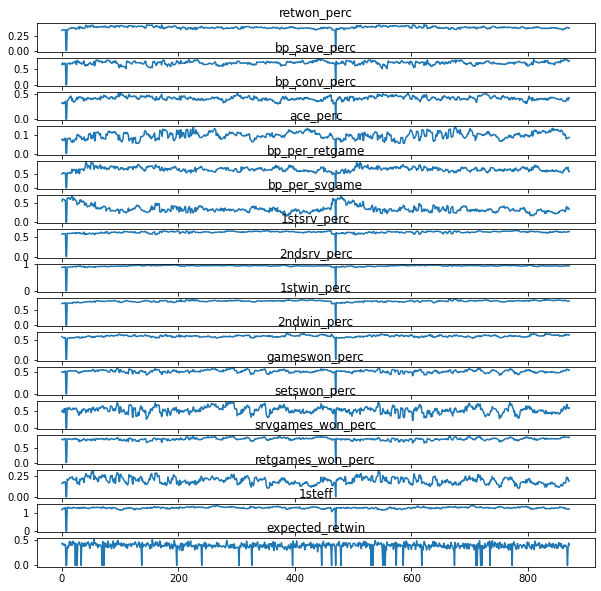

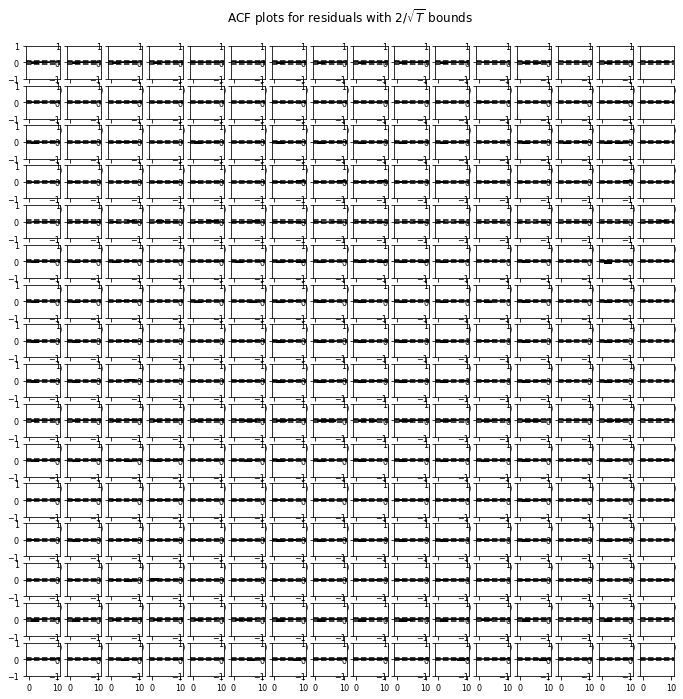

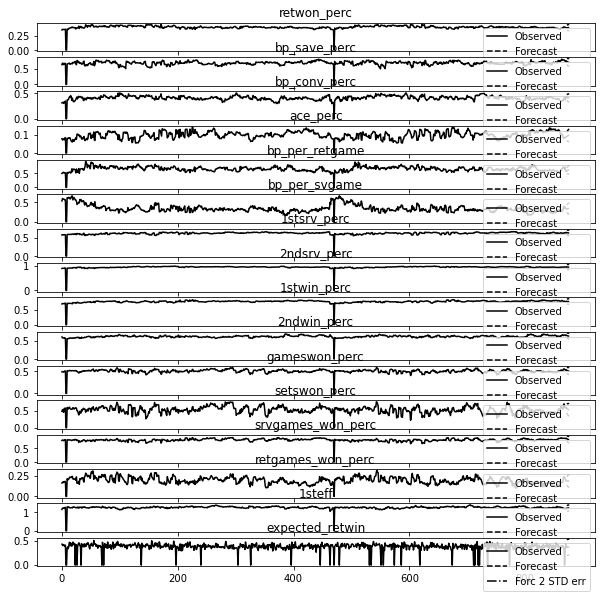

In [55]:
#AGASSI FUCKED THIS UP IDK WHY
#Not working with Roddick or Tstitsipas either
#was giving array must not have any inf or nan values in forecast line 
#tried checking, don't think there are any 
#keep getting things like "LinAlgError: 10-th leading minor of the array is not positive definite"

from statsmodels.tsa.api import VAR
from matplotlib.pyplot import figure

#want to make the diagnostic plots bigger, this isn't working though
figure(num=None, figsize=(50, 60), dpi=80, facecolor='w', edgecolor='k')

test_size=5


for player in plot_players:
    print("starting: ", player)
    drop_cols=["pnum", "srvwon_perc", "df_perc", "expected_srvwin"]
    print(player_dict[player].loc[:, drop_cols].describe())
    p_df=player_dict[player].select_dtypes(np.number).drop(drop_cols, axis=1)#.drop("pnum", axis=1)#
    
    print("p_df inf: ", p_df.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))
    print("p_df na: ", p_df.select_dtypes(np.number).isnull().sum())

    #print(p_df)
    train, test = p_df.iloc[1:p_df.shape[0]-test_size, :], p_df.iloc[p_df.shape[0]-test_size:, :]
    
    print("train inf: ", p_df.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))
    print("test inf: ", p_df.select_dtypes(np.number).apply(lambda s: s[~np.isfinite(s)].sum()))
    print("train na: ", p_df.select_dtypes(np.number).isnull().sum())
    print("test na: ", p_df.select_dtypes(np.number).isnull().sum())
    
    print("finite test: ", np.isfinite(p_df).all(), np.isfinite(train).all(), np.isfinite(test).all())
    #print(np.asarray(train))
    model=VAR(train)
    model_fit=model.fit(maxlags=20, ic="aic")#, ic="aic")
    print(model_fit.summary())
    model_fit.plot()
    model_fit.plot_acorr()
    #print("test: ", test)
    #print("size: ", test_size)
    pred=model_fit.forecast(y=np.asarray(test), steps=int(test_size))
    #print(pred)
    
    
    model_fit.plot_forecast(steps=int(test_size))
    
    print("done with: ", player)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA




warnings.filterwarnings("ignore")

player_col_dict={}
for player in plot_players:
    col_dict={}
    for col in imp_plot_cols:
        print("col: ", col)
        p_df=player_dict[player]
        train, test = p_df.iloc[1:p_df.shape[0]-test_size, :].loc[:, col], p_df.iloc[p_df.shape[0]-test_size:, :].loc[:, col]
        #print(train.head())
        # train autoregression
        #find this lag from other things
        pred_rmse_list=[]
        forecast_rmse_list=[]
        p_range=list(range(0,25, 5))
        q_range=list(range(0,25, 5))
        d_range=[0,1]
        orders=list(itertools.product(p_range, d_range, q_range))
        #orders=zip(p_range, d_range, q_range)
        #print(orders)
        #print(list(orders))
        #for order in orders:
        for d in d_range:
            print("starting order: ", order)
            
            model = ARIMA(train, order=(p_range, d, q_range))
            model_fit = model.fit()
            #print('Coefficients: %s' % model_fit.params)
            # make predictions
            lag_predictions = model_fit.predict(start=train.shape[0], end=train.shape[0]+test.shape[0]-1, dynamic=False)
            lag_forecast = model_fit.forecast(steps=test_size)
            #print("preds: ", lag_predictions)
            #print("test: ", test)
            #for i in range(len(lag_predictions)):
            #    print('predicted=%f, expected=%f' % (lag_predictions.iloc[i], test.iloc[i]))
            pred_rmse = np.sqrt(mean_squared_error(test, lag_predictions))
            forecast_rmse=np.sqrt(mean_squared_error(test, lag_forecast))
            print("order (pRMSE): ", order, " : "+str(pred_rmse))
            print("order (fRMSE): ", order, " : "+str(forecast_rmse))
            pred_rmse_list.append(pred_rmse)
            forecast_rmse_list.append(forecast_rmse)
        print("differences: ", [pred-forecast for pred, forecast in zip(pred_rmse_list, forecast_rmse_list)])
        min_rmse=min(rmse_list)
        print(np.argmin(rmse_list))
        best_lag=lag_range[np.argmin(rmse_list)]
        best_order=orders[np.argmin(pred_rmse_list)]
        col_dict[col]=best_order
        model = ARIMA(train, order=best_order)
        model_fit = model.fit()
        print('Coefficients: %s' % model_fit.params)
        # make predictions
        #predictions = model_fit.predict(start=train.shape[0], end=train.shape[0]+test.shape[0]-1, dynamic=False)
        predictions=model_fit.forecast(steps=test_size)
        #print("preds: ", lag_predictions)
        #print("test: ", test)
        #for i in range(predictions.shape[0]):
        #    print('predicted=%f, expected=%f' % (predictions.iloc[i], test.iloc[i]))
        rmse = np.sqrt(mean_squared_error(test, predictions))
        print("test", test)
        print("predictions", predictions)
        print('Test RMSE: %.3f' % rmse)
        # plot results
        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.show()
    player_col_dict[player]=col_dict

In [ ]:
player_col_dict

### H2H Stats

In [ ]:
def row_upto(row):
    return row.name

def only_wind(df, window):
    rows=df.shape[0]
    if rows<=window-1:
        return rows
    else:
        return window-1
    
def select(df, wind):
    return df.select_dtypes(include=np.number).tail(only_wind(df, wind))#.iloc[only_wind(df, wind), :]

def h2h_oneplayer(player1, player2, match_df, up_to, h2h=True):
    if h2h:
        p1=match_df.loc[(match_df.index<up_to)&(match_df["name_p1"]==player1)&(match_df["name_p2"]==player2), match_df.columns.str.endswith("p1")]
        p2=match_df.loc[(match_df.index<up_to)&(match_df["name_p2"]==player1)&(match_df["name_p1"]==player2), match_df.columns.str.endswith("p2")]
    else:
        p1=match_df.loc[(match_df.index<up_to)&(match_df["name_p1"]==player1), match_df.columns.str.endswith("p1")]
        p2=match_df.loc[(match_df.index<up_to)&(match_df["name_p2"]==player1), match_df.columns.str.endswith("p2")]
        
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns) if x not in ["age", "rank_log", "rank_points_log"]]
    
    window=WINDOW
    
    if p1.empty:
        p2.columns=good_cols
       
        both=select(p2, window).sum()
    elif p2.empty:
        p1.columns=good_cols
      
        both=select(p1, window).sum()

    else:
        p1.columns=good_cols
        p2.columns=good_cols
    
        both=pd.concat([select(p1, window),  select(p2, window)]).sort_index().tail(window)\
            .sum()
        
    return both
        

def h2h(player1, player2, match_df, up_to):
    
    start=timer()
    
    p1=h2h_oneplayer(player1, player2, match_df, up_to)
    p2=h2h_oneplayer(player2, player1, match_df, up_to)
    
    p1.index=[c+"_p1" for c in p1.index.tolist()]
    p2.index=[c+"_p2" for c in p2.index.tolist()]
    
   
    both=pd.concat([p1,p2])
    
    both_perc=percentage_calculations(both)
    both_perc_drop=drop_non_perc(both_perc)
 
    if up_to%1000==0:
        print(up_to, " : ", timer()-start)
    return both_perc_drop



In [ ]:
h2h_dict={"name_p1": ["Roger Federer", "Novak Djokovic"], "name_p2": ["Rafael Nadal",  "Rafael Nadal"]}
h2h_test=pd.DataFrame(h2h_dict)
h2h_test

In [ ]:
sm_names.reset_index().loc[0:100, ["name_p1", "name_p2", "index"]]

In [ ]:
#sm_h2h=sm_names.reset_index()[["name_p1", "name_p2", "index"]]

#sm_h2h["name_p1"]

In [ ]:
#h2h_df=h2h(sm_h2h["name_p1"], sm_h2h["name_p2"], sm_names, sm_h2h["index"])
#h2h_df
sm_names.columns

##### Actually making h2h_df, only use if trying something new

In [ ]:
start=timer()
h2h_df=sm_names.reset_index()[["name_p1", "name_p2", "index"]].apply(lambda row: h2h(row["name_p1"], row["name_p2"], sm_names, row["index"]), axis=1)
#rolling_df=sm_names.reset_index()[["name_p1", "name_p2", "index"]].apply(lambda row: h2h(row["name_p1"], row["name_p2"], sm_names, row["index"], h2h=False), axis=1)
#h2h_df.loc[(h2h_df["name_p1"]=="Roger Federer")&(h2h_df["name_p2"]=="Rafael Nadal")]
end=timer()
print(end-start)
#h2h_df.head()

In [ ]:
h2h_df[["name_p1", "name_p2"]]=sm_names[["name_p1", "name_p2"]].copy()
constant_cols=["name", "age", "rank_log", "rank_points_log"]
constant_p1p2=[c+side for c in constant_cols for side in ["_p1", "_p2"]]
h2h_df[constant_p1p2]=sm_names[constant_p1p2].values

In [ ]:
#h2h_df

In [ ]:
h2h_df.to_csv(os.path.join(PATH, "h2h_df.csv"), index=False)

In [ ]:
h2h_df=pd.read_csv(os.path.join(PATH, "h2h_df.csv"))
h2h_df

In [ ]:
h2h_df[((h2h_df["name_p1"]=="Novak Djokovic")|(h2h_df["name_p1"]=="Gael Monfils"))&((h2h_df["name_p2"]=="Novak Djokovic")|(h2h_df["name_p2"]=="Gael Monfils"))]

##### Fill NAs

In [ ]:

print(h2h_df.isna().sum())

Fill missing values with 0s. This makes sense as there will be no difference in head to head matchup stats if the players haven't played each other before, which is where the NA's should be appearing from. The number of NA's indicates that there won't be too much value from the H2h columns if we do this filling, but there isn't too much of a choice. 

In [ ]:
#fill inf values with 0
names=h2h_df[["name_p1", "name_p2"]].values
h2h_df.fillna(0, inplace=True)
stack=h2h_df.stack()
stack[stack==np.inf]=0
h2h_df=stack.unstack()
h2h_df=h2h_df.loc[:, ~h2h_df.columns.isin(["name_p1", "name_p2"])].astype("float64")
h2h_df[["name_p1", "name_p2"]]=names
print(h2h_df.isna().sum())
print(h2h_df.dtypes)

In [ ]:
sm_names.iloc[[6719, 8041, 8475], :]

##### Combine H2H to everything else

In [ ]:
#can only run this once or you get multiple h2h_ at the front of the column names
h2h_df.columns=["h2h_"+col for col in h2h_df.columns.tolist()]
h2h_df.head()

In [ ]:
sm_h2h=pd.concat([sm_perc, h2h_df], axis=1)
print(sm_perc.isnull().sum())
print(h2h_df.isnull().sum())

### Difference columns

In [ ]:
print(sm_perc.columns)
h2h_not_params=["surface", "Date", "Win"]
h2h_diff_params=list(np.unique(["_".join(x.split("_")[:-1]) for x in sm_perc.columns[~sm_perc.columns.isin(h2h_not_params)]]))
print(h2h_diff_params)
p1_p2_h2h_dict={param: [param+"_"+x for x in ["p1", "p2"]]+["h2h_"+param+"_"+x for x in ["p1", "p2"]] for param in h2h_diff_params}
p1_p2_h2h_dict

In [ ]:
sm_h2h.to_csv(os.path.join(PATH, "sm_h2h.csv"), index=False)

In [ ]:
#get all columns to subtract
#print(h2h_diff_params)
h2h_params=h2h_diff_params+["h2h_"+param for param in h2h_diff_params]
diff_params=[x for x in h2h_diff_params if x not in ["name", "hand", "ioc", "seed"]]
#print(h2h_params, diff_params)
print(diff_params)
def create_diff(df, num_cols):
    #num_cols=df.select_dtypes(include=np.number).columns.tolist()
    
    del_list=[]
    for col in num_cols:
        print(col)
        #get the player 1, player columns for the stat
        p1, p2, p1_h2h, p2_h2h=p1_p2_h2h_dict[col][0], p1_p2_h2h_dict[col][1], p1_p2_h2h_dict[col][2], p1_p2_h2h_dict[col][3]
        #subtract p1 and p2 stat to get differene columns
        df[col+"_diff"]=df[p1]-df[p2]
        df["h2h_"+col+"_diff"]=df[p1_h2h]-df[p2_h2h]
        del_list.extend([p1,p2, p1_h2h, p2_h2h])
    #drop all p1 and p2 columns, leaving only the difference columns
    new_df=df.drop(del_list, axis=1)
    return new_df
sm_diff=create_diff(sm_h2h, diff_params)
sm_diff


In [ ]:
sm_h2h.isnull().sum()

In [ ]:
sm_diff.to_csv(os.path.join(PATH, "sm_diff.csv"), index=False)

In [ ]:
pd.set_option('display.max_columns', 500)
sm_diff.loc[sm_diff["h2h_bp_per_retgame_diff"]==np.inf]

In [ ]:
names=sm_2000.loc[[270], ["name_p1", "name_p2"]].values[0]
print(names[0])
sm_2000[((sm_2000["name_p1"]==names[0])|(sm_2000["name_p1"]==names[1]))&((sm_2000["name_p2"]==names[0])|(sm_2000["name_p2"]==names[1]))]

In [ ]:
#plot all the difference columns just made
plot_diff_cols=[x for x in sm_diff.columns.tolist() if x.split("_")[-1]=="diff"]
plot_h2h_cols=[x for x in plot_diff_cols if x.split("_")[0]=="h2h"]

print(sm_diff[plot_diff_cols].dtypes)
print(sm_diff[plot_h2h_cols].dtypes)
print(h2h_df.dtypes)


sm_diff[plot_diff_cols].hist(bins=20, figsize=(16,20))
sm_diff[plot_h2h_cols].hist(bins=20, figsize=(16,20))
#sm_diff["h2h_1steff_diff"].plot.hist()

In [ ]:
#up close plot of difference of log rank
sm_diff["rank_log_diff"].plot.hist(bins=50)

In [ ]:
x=np.log(sm_2000["rank_p1"])-np.log(sm_2000["rank_p2"])
x.plot.hist(bins=20)

In [ ]:
#might want to create dummy columns for some categorical variables
sm_2000_dummies=sm_diff.copy()
#sm_2000_dummies=pd.get_dummies(sm_diff, columns=["best_of", "round"])#["hand_p1", "hand_p2"])#["tourney_level", "surface", "round", "winner_hand", "loser_hand"])
#drop a couple of columns to deal with later
sm_2000_dummies=sm_2000_dummies.drop(["score", "ioc_p1", "minutes",
                                      "ioc_p2", "Year", "hand_p1", "hand_p2", 
                                      "tourney_level", "draw_size", "surface",
                                      "rank_diff", "rank_points_diff", "round", "best_of",
                                      "h2h_name_p1", "h2h_name_p2"], axis=1)

#these columns might be training on the answer in a way, so remove them for now
#also multicollinearity concerns, since there are percent columns for each of these
too_good_cols=["1stIn_diff", "1stWon_diff", 
               "2ndIn_diff", "2ndWon_diff", 
               "SvGms_diff", "svpt_diff", 
               "bpSaved_diff", "ace_diff",
               "df_diff", "1steff_diff", "2ndeff_diff",
              "srv_ptswon_diff", "ret_pts_diff", "ret_won_diff"]

too_good_h2h=["h2h_"+tgc for tgc in too_good_cols]

too_good_all=too_good_cols+too_good_h2h

sm_2000_dummies=sm_2000_dummies.drop(too_good_all, axis=1)

sm_2000_dummies.fillna(0, inplace=True)
sm_2000_dummies.head()

#this is the final form of the data, so save it 
sm_2000_dummies.to_csv(os.path.join(PATH, "clean_matches.csv"), index=False)

In [ ]:
sm_2000_dummies.corr()

In [ ]:
#correlation stuff
corr=sm_2000_dummies.corr().abs()
indices = np.where(corr > 0.75)
indices = [(corr.index[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices
#sm_2000_dummies.corr()[np.argsort(sm_2000_dummies.corr().values().abs())]
#corr=sm_2000_dummies.corr().abs().unstack()
#corr[corr!=1.].sort_values(ascending=False)

# Method 1

Form finding after training, only for new matches

### Test-Train Split

In [ ]:
print(np.shape(sm_2000_dummies["Win"]), np.shape(sm_2000_dummies.drop("Win", axis=1)))
x_train, x_test, y_train, y_test=train_test_split(sm_2000_dummies.drop("Win", axis=1), 
                                                  sm_2000_dummies["Win"], 
                                                  test_size=0.3,
                                                  random_state=RANDOM_STATE)

##### Scaling the data

In [ ]:
#normalize the data
scaler=StandardScaler()

x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)
#for param in params:
#    x_train_norm.loc[:,win_lose_dict[param]].plot.hist(alpha=0.5)

### Logistic Regression (CV)

In [ ]:
def coefficient_df(x_train, clf):
    return pd.DataFrame({"Feature":x_train.columns.tolist(),"Coefficients":clf.coef_[0]})

In [ ]:
clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_norm, y_train)

In [ ]:
y_pred=clf.predict(x_test_norm)
coef_df=coefficient_df(x_train, clf)
print(coef_df.head(50))
print(clf.score(x_test_norm, y_test))

In [ ]:
confusion_matrix(y_test, y_pred)

### "Lasso" (L1 penalty) Logistic

In [ ]:
clf_l1=LogisticRegression(penalty="l1", solver="liblinear")\
                        .fit(x_train_norm, y_train)

In [ ]:
y_pred_l1=clf_l1.predict(x_test_norm)
coef_df_l1=coefficient_df(x_train, clf_l1)
print(coef_df_l1.head(50))
print(clf_l1.score(x_test_norm, y_test))

In [ ]:
confusion_matrix(y_test, y_pred_l1)

##### Run CV again, with lasso selected columns

In [ ]:
sparse_index=np.where(clf_l1.coef_[0]!=0.)[0]
lasso_df=x_train_norm[:,sparse_index]
lasso_test=x_test_norm[:, sparse_index]


In [ ]:
clf_l1_CV=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(lasso_df, y_train)


In [ ]:
y_pred_l1_CV=clf_l1_CV.predict(lasso_test)
coef_df_l1_CV=coefficient_df(x_train.iloc[:,sparse_index], clf_l1_CV)
print(coef_df_l1_CV.head(50))
print(clf_l1_CV.score(lasso_test, y_test))

In [ ]:
confusion_matrix(y_test, y_pred_l1_CV)

### FDR Model Selection

In [ ]:
FDR=SelectFdr(f_classif, alpha=0.01)
x_train_new=FDR.fit_transform(x_train_norm, y_train)
x_test_new=FDR.transform(x_test_norm)
print(x_train.shape, x_train_new.shape)

In [ ]:
fdr_clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_new, y_train)
fdr_pred=fdr_clf.predict(x_test_new)


In [ ]:
#fdr_coef_df=coefficient_df(x_train_new, fdr_clf)
#print(fdr_coef_df.head(50))
print(fdr_clf.score(x_test_new, y_test))
confusion_matrix(y_test, fdr_pred)

#### ROC

In [ ]:
#predict_proba gets both predictions and probabilities
#CHECK THIS
#shamelessly stolen from stackoverflow
def ROC_plot(x_test, y_test):
    probs = clf.predict_proba(x_test)
    #print(*probs)
    preds = probs[:,1]
    #print(preds)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
ROC_plot(x_test_norm, y_test)

### SVM

In [ ]:
lin_svm=svm.LinearSVC().fit(x_train_norm, y_train)
svm_pred=lin_svm.predict(x_test_norm)
confusion_matrix(y_test, svm_pred)
lin_svm.score(x_test_norm, y_test)


Should do some SVM diagnostics here

### Naive Bayes

In [ ]:
gnb=GaussianNB()
gnb_fit=gnb.fit(x_train_norm, y_train)
gnb_pred=gnb_fit.predict(x_test_norm)
confusion_matrix(y_test, gnb_pred)
gnb_fit.score(x_test_norm, y_test)

Should do some naive bayes diagnostics here

## Predict New Matches

##### Use above models (which are player agnostic)
##### Find the players "form" somehow
##### Ie their recent 1stIn, all the other stats
##### Plug those into the model for each player, predict the winner

In [ ]:
#get the return stats (slams and masters has the names of the players still)
#sm_win=win_column(slams_and_masters, RANDOM_STATE)
print(gcm_names.head())
sm_rets=ret_stats(gcm_names)
#do the same percent calculations as before
player_matches=percentage_calculations(sm_rets)
#log transform the rank and rank points coluumns
rank_transform(player_matches)
#do the w and l to p1 and p2 renaming
sm_index=player_matches.columns.tolist()
player_matches.rename(columns=rename_win_lose, inplace=True)

#player_matches.head()
imp_cols=list(win_lose_dict.keys())
stat_cols=[x for x in imp_cols if x not in ["hand", "ioc"]]
#player_matches.head()
#slams_and_masters.loc[slams_and_masters["winner_name"]=="Roger Federer"]["winner_ht"]
#stats_to_avg=list(win_lose_dict.keys())-["age"]

In [ ]:
player_matches.head()

In [ ]:
def player_stats(player, match_df):
    #get the past match statistics for each player in a new match
    p1_df=match_df.loc[match_df["name_p1"]==player, p1_p2_param_dict["p1"]+["hand_p2", "minutes", "surface", "tournament_date","name_p1"]]
    p1_df["pnum"]=1
    p1_ind=np.where(match_df["name_p1"]==player)
    p2_df=match_df.loc[match_df["name_p2"]==player, p1_p2_param_dict["p2"]+["hand_p1", "minutes", "surface", "tournament_date", "name_p2"]]
    p2_df["pnum"]=2
    p2_ind=np.where(match_df["name_p2"]==player)
    #rename a few of the columns to p1 and p2 have the same name for shared columns
    p1_df.columns=imp_cols+["opp_hand", "minutes", "surface", "Date", "name", "pnum"]
    p2_df.columns=imp_cols+["opp_hand", "minutes", "surface", "Date", "name", "pnum"]
    
    #combine player 1 stats with player 2 stats
    player_df=pd.concat([p1_df, p2_df]).sort_values(by="Date")
    return player_df

#player_df=player_stats("Roger Federer", player_matches)
#print(p1_ind, p2_ind, player_df.index)

In [ ]:
#print(p1_df[["1stIn", "surface"]].head(), "\n", p2_df[["1stIn", "surface"]].tail(), "\n", player_df[["1stIn", "surface"]].tail())

In [ ]:
player_df

##### Average

In [ ]:
def avg_stats(player, match_df, surface, opp_hand):
    #get player stats for a given player
    player_df=player_stats(player, match_df)
    #average all the stats across time, only including matches on surface type of new match as well as opponent hand
    avg_stats=player_df[(player_df["surface"]==surface)&(player_df["opp_hand"]==opp_hand)][stat_cols+["minutes"]].mean()
    avg_stats["name"]=player
    return avg_stats

print(stat_cols)
avg_stats("Roger Federer", player_matches, "Grass", "R")

##### Moving Average

In [ ]:
def moving_avg(player, match_df, surface, opp_hand, window):
    #get player stats for a given player
    player_df=player_stats(player, match_df)
    #get a rolling average of all stats, only on surface of new match and against the same opposing hand
    #only get most recent row of player's average, thats the players "form"
    moving_stats=player_df[(player_df["surface"]==surface)&(player_df["opp_hand"]==opp_hand)][stat_cols+["minutes"]].rolling(window=window, min_periods=1).mean().iloc[-1,:]
    moving_stats["name"]=player
    return moving_stats
moving_avg("Roger Federer", player_matches, "Clay", "L", 5)

NOTE: I removed opp hand from the indexing. Seemed like it was making the lefties too overpowered because of nadal. Removing it made the probabilities pass the eye test better (Nadal shouldnt have a 90+% chance to beat federer on grass Im pretty sure). Maybe think of a better way to add it back in. Didn't remove it from the other averaging methods because EW is best so probably only going to use it

##### Exponential weighted average

In [ ]:
def ew_avg(player, match_df, surface, opp_hand, span):
    #get all player stats for a given player
    player_df=player_stats(player, match_df)
    #get a exponential weighted average for all stats, only on the surface of the new match
    #only get most recent row of the weighted average, thats the players "form"
    ew_stats=player_df[(player_df["surface"]==surface)][stat_cols+["minutes"]].ewm(span=span, adjust=False).mean().iloc[-1,:]
        #ew_stats=player_df[(player_df["surface"]==surface)].ewm(span=span).mean().plot(x="Date", y="1stsrv_perc")
    ew_stats["name"]=player
    return ew_stats
print(ew_avg("Roger Federer", player_matches, "Clay", "L", 10))
#print(ew_avg("Rafael Nadal", player_matches, "Clay", "R", 10))

##### Find player form

In [ ]:
def get_p1p2_dfs(new_match_df, player_matches, agg_type, window=None, span=None):
    #can choose between types of "form finding". Either average, rolling average, or exp weighted average
    #then apply the relevant function to player 1 and player 2 separately
    if agg_type=="mean":
        p1_df=new_match_df.apply(lambda x: avg_stats(x["name_p1"], player_matches, x["surface"], x["hand_p2"]), axis=1)
        p2_df=new_match_df.apply(lambda x: avg_stats(x["name_p2"], player_matches, x["surface"], x["hand_p1"]), axis=1)
    elif agg_type=="rolling": 
        p1_df=new_match_df.apply(lambda x: moving_avg(x["name_p1"], player_matches, x["surface"], x["hand_p2"], window=window), axis=1)
        p2_df=new_match_df.apply(lambda x: moving_avg(x["name_p2"], player_matches, x["surface"], x["hand_p1"], window=window), axis=1)
    elif agg_type=="exp":
        p1_df=new_match_df.apply(lambda x: ew_avg(x["name_p1"], player_matches, x["surface"], x["hand_p2"], span=span), axis=1)
        p2_df=new_match_df.apply(lambda x: ew_avg(x["name_p2"], player_matches, x["surface"], x["hand_p1"], span=span), axis=1)
    else:
        print("Enter either 'mean', 'rolling', or 'exp' as the agg_type")
    
    return p1_df, p2_df

#get_p1p2_dfs(test_df, player_matches, agg_type="exp", span=10)

##### Actual Prediction

In [ ]:
def new_predictions(new_match_df, player_matches, clf, agg_type="exp", window=None, span=None):
    '''new_match_df has the form name_p1, name_p2, surface, hand'''
    #get the "form" dfs for both player1 and player2, depending on agg choice
    p1_df, p2_df=get_p1p2_dfs(new_match_df, player_matches, agg_type, window, span)
    
    #combine the two dfs
    both_players=p1_df.merge(p2_df, left_index=True, right_index=True, suffixes=("_p1", "_p2"))
    
    #average the minutes together, change this if there's a better idea
    both_players["minutes"]=both_players[["minutes_p1", "minutes_p2"]].mean(axis=1)
    both_players_drop=both_players.drop(["name_p1", "name_p2", "minutes_p1", "minutes_p2"], axis=1)
    
    #might want to add some dummy variables for surface or hand, but not included right now
    both_players_dummies=both_players_drop.copy()
    #both_players_dummies=pd.get_dummies(both_players_drop, columns=["surface"])
    
    #get all the difference columns between the two players
    both_players_diff=create_diff(both_players_dummies, diff_params)
    #select only the relevant columns and put them in the same order as the trained model
    both_players_ord=both_players_diff[x_train.columns]
    
    #scale the data with the same scaler as the trained model
    both_players_norm=scaler.transform(both_players_ord)
     
    #predict the winner for the new matches using the trained model and get the win probabilities
    new_pred=clf.predict(both_players_norm)
    probs=clf.predict_proba(both_players_norm)
    
    return new_pred, probs

test_df=pd.DataFrame({"name_p1": ["Novak Djokovic", "Roger Federer", "Roger Federer"],
                      "name_p2": ["Novak Djokovic", "Rafael Nadal", "Roger Federer"],
                      "surface": ["Clay", "Clay", "Clay"],
                      "hand_p1": ["R", "R", "R"],
                      "hand_p2": ["R", "L", "R"]})

new_predictions(test_df, player_matches, clf, span=20)
#print(x_train.columns)

In [ ]:
def winner_probs(new_match_df, player_matches, clf, agg_type="exp", window=None, span=None):
    #get win predictions and probabilities
    preds, probs=new_predictions(new_match_df, player_matches, clf, agg_type, window, span)
    
    #get arrays of the winner's names and the associated probabilities of winning
    players=new_match_df[["name_p1", "name_p2"]].values
    winners=players[range(players.shape[0]), preds]
    win_prob=probs[range(players.shape[0]), preds]
    
    return winners, win_prob

winner_probs(test_df, player_matches, clf, span=20)

In [ ]:
def pretty_predictions(new_match_df, player_matches, clf, agg_type="exp", window=None, span=None):
    #print the matchup, the predicted winner, and the probability of winning in a nice looking format
    winners, win_prob=winner_probs(new_match_df, player_matches, clf, agg_type, window, span)
    match=new_match_df["name_p1"]+" vs. "+new_match_df["name_p2"]
    match_pred=[match[i]+" : "+winners[i]+" (%.2f)" % win_prob[i] for i in range(len(new_match_df.index))]
    for p in match_pred:
        print(p)
pretty_predictions(test_df, player_matches, clf, agg_type="exp", window=10, span=10)

# Method 2

Use form finding for training

In [ ]:
player_matches.columns=sm_index
player_matches.reset_index(drop=True, inplace=True)

#### Win Column again

In [ ]:
#get the return stats (slams and masters has the names of the players still)
#print(pm_copy.head())
print(player_matches.columns)

sm_win=win_column(player_matches, RANDOM_STATE)
#sm_rets=ret_stats(sm_win)
#do the same percent calculations as before

#player_matches=percentage_calculations(sm_rets)
#log transform the rank and rank points coluumns
#rank_transform(player_matches)
#do the w and l to p1 and p2 renaming
#print(pm_win)
drop_cols=["best_of", "draw_size", "round", "score", "tourney_level", "Year"]
pm_rename=sm_win.rename(columns=rename_win_lose).drop(drop_cols, axis=1)#player_matches[player_matches.columns[~player_matches.columns.isin(["Win"])]].rename(columns=rename_win_lose)
pm_rename.head()

### Rolling average for each player (as both p1 and p2 together)

In [ ]:
#pm_rename["flip"]=pm_rename["sorted_players"]==pm_rename["players"]
#player_groups=pm_rename.groupby(["players"]).mean().reset_index()
#num_matches=pm_rename.groupby(["players"]).agg({"1stIn_p1": 'count'}).rename({"1stIn_p1": "num_matches"}, axis=1)
#group_weights=player_groups.merge(num_matches, on="players")
#group_weights

### Head to Head Stats

In [ ]:
copied_pm=pm_rename.copy()
def h2h_oneplayer(player1, player2, match_df):
    p1=match_df.loc[(match_df["name_p1"]==player1)&(match_df["name_p2"]==player2), match_df.columns.str.endswith("p1")]
    p2=match_df.loc[(match_df["name_p2"]==player1)&(match_df["name_p1"]==player2), match_df.columns.str.endswith("p2")]
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    p1.columns=good_cols
    p2.columns=good_cols
    both=pd.concat([p1, p2]).mean()
    both["player"]=player1
    #both["opp"]=player2
    return both

def h2h(player1, player2, match_df):
    p1=h2h_oneplayer(player1, player2, match_df)
    p2=h2h_oneplayer(player2, player1, match_df)
    
    p1.index=[c+"_p1" for c in p1.index.tolist()]
    p2.index=[c+"_p2" for c in p2.index.tolist()]
    
    both=pd.concat([p1,p2]).to_frame().transpose().drop(["player_p1", "player_p2"], axis=1)
    
    return both

#h2h_oneplayer("Roger Federer", "Rafael Nadal", copied_pm)
h2h("Roger Federer", "Rafael Nadal", copied_pm)

In [ ]:
def surface_ew_avg(player_df, span, surface):
    return player_df[player_df["surface"]==surface][stat_cols+["minutes"]].ewm(span=span).mean()

def no_surface_ew_avg(player_df, span):
    return player_df[stat_cols+["minutes"]].ewm(span=span).mean()

def avg_dfs(df1, df2):
    return (df1.add(df2))/2

In [ ]:
def player_stats_avg(player, match_df, surface, span):
    player_df=player_stats(player, match_df)
    ew=no_surface_ew_avg(player_df, span)
    ew_surface=surface_ew_avg(player_df, span, surface)
    ew_avg=avg_dfs(ew, ew_surface)
    print(ew, ew_surface, ew_avg)
    ew_stats=player_df[stat_cols+["minutes"]].ewm(span=span).mean()
    ew_stats["name"]=player
    ew_stats[["pnum", "Date", "hand", "ioc", "surface"]]=player_df[["pnum", "Date", "hand","ioc", "surface"]].copy()
    #ew_stats["Date"]=player_df["Date"].copy()
    #ew_s
    return ew_stats

player_stats_avg("Roger Federer", pm_rename, "Hard", 5)

### Combine all players rolling averages

In [ ]:
def merge_pstats(player, match_df, surface, span, empty_df):
    ew_stats=player_stats_avg(player, match_df, surface, span).reset_index()
    ew_stats=ew_stats.reindex(sorted(ew_stats.columns), axis=1)
    
    ew_p1=ew_stats[ew_stats["pnum"]==1]
    ew_p2=ew_stats[ew_stats["pnum"]==2]
    
    good_ew_cols=ew_stats.drop(["index", "minutes", "name", "pnum"], axis=1).columns.tolist()
    
    p1_params=[c+"_p1" if c not in ["Date", "surface"] else c for c in good_ew_cols]
    p2_params=[c+"_p2" if c not in ["Date", "surface"] else c for c in good_ew_cols]
    
    p1_ind=ew_p1["index"].values
    p2_ind=ew_p2["index"].values
    
    return ew_p1, ew_p2, p1_params, p2_params
    
    #empty_df=pd.DataFrame().reindex_like(match_df)
    
    #empty_df.loc[p1_ind, ["name_p1", "Date"]]=ew_p1[["name", "Date"]]
    #empty_df.loc[p2_ind, ["name_p2", "Date"]]=ew_p2[["name", "Date"]]
    
    #empty_df.loc[p1_ind, p1_params]=ew_p1.drop(["index", "minutes", "name", "pnum"], axis=1).values
    #empty_df.loc[p2_ind, p2_params]=ew_p2.drop(["index", "minutes", "name", "pnum"], axis=1).values
    #return empty_df

#merged=merge_pstats("Roger Federer", pm_rename, "Hard", 5)
#merged

In [ ]:
#CHECK THE WIN COLUMN BY EYE IT LOOKS WRONG
def apply_merging(match_df, surface, span):
    avg_df=pd.DataFrame().reindex_like(match_df)
    avg_df=avg_df.reindex(sorted(avg_df.columns), axis=1)
    players=np.unique(match_df[["name_p1", "name_p2"]].values)
    for p in players:
        ew_p1, ew_p2, p1_params, p2_params=merge_pstats(p, match_df, surface, span, avg_df)
        #print("EW name: ", ew_p1.name)
        p1_ind=ew_p1["index"].values
        p2_ind=ew_p2["index"].values
        
        avg_df.loc[p1_ind, ["name_p1", "tournament_date", "surface"]]=ew_p1[["name", "Date", "surface"]].values
        avg_df.loc[p2_ind, ["name_p2", "tournament_date", "surface"]]=ew_p2[["name", "Date", "surface"]].values
        
    
        avg_df.loc[p1_ind, p1_params]=ew_p1.drop(["index", "minutes", "name", "pnum"], axis=1).values
        avg_df.loc[p2_ind, p2_params]=ew_p2.drop(["index", "minutes", "name", "pnum"], axis=1).values
    
    avg_df.fillna(0, inplace=True)
    return avg_df

pd.set_option('display.max_columns', 500)
#for court in ["Hard", "Grass", "Clay"]:
merged=apply_merging(pm_rename, "Hard", 5).drop(["ioc_p1", "ioc_p2"], axis=1)
merged["Win"]=pm_rename.Win.values
merged
        

### Difference Columns

In [ ]:
diff=create_diff(merged, diff_params)
diff

In [ ]:
diff.isnull().sum()

### Test-Train Split

In [ ]:
train_drop=["Win", "hand_p1", "hand_p2", "minutes", "name_p1", "name_p2", "surface", "tournament_date", "Date"]
too_good_drop=["1stIn_diff", "1stWon_diff", "2ndWon_diff"]

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(diff.drop(train_drop, axis=1), 
                                                  diff["Win"], 
                                                  test_size=0.3,
                                                  random_state=RANDOM_STATE)

### Scaling

In [ ]:
scaler=StandardScaler()

x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)

### Logistic Regression

In [ ]:
clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_norm, y_train)

In [ ]:
y_pred=clf.predict(x_test_norm)
coef_df=coefficient_df(x_train, clf)
print(coef_df.head(50))
print(clf.score(x_test_norm, y_test))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
ROC_plot(x_test_norm, y_test)

## Test Unseen Matches

In [ ]:
test_df=pd.DataFrame({"name_p1": ["Novak Djokovic", "Roger Federer", "Roger Federer"],
                      "name_p2": ["Roger Federer", "Rafael Nadal", "Roger Federer"], 
                      "surface": ["Hard", "Hard", "Hard"]})

In [ ]:
def recent_row(player, match_df):
    #recent_p1=match_df[(match_df["name_p1"]==player)].sort_values(by="tournament_date").iloc[-1, :]
    #recent_p2=match_df[(match_df["name_p2"]==player)].sort_values(by="tournament_date").iloc[-1, :]
    
    most_recent_p1p2=match_df[(match_df["name_p1"]==player)|(match_df["name_p2"]==player)].sort_values(by="tournament_date").iloc[-1, :]
    
    if most_recent_p1p2["name_p1"]==player:
        most_recent=most_recent_p1p2.loc[most_recent_p1p2.index.str.endswith("p1")]
    else:
        most_recent=most_recent_p1p2.loc[most_recent_p1p2.index.str.endswith("p2")]
    
    #print("p1: ", recent_p1["tournament_date"])
    #print("p2: ", recent_p2["tournament_date"])
    #print("comp: ", recent_p1["tournament_date"]>recent_p2["tournament_date"])
    
    #if recent_p1["tournament_date"]>recent_p2["tournament_date"]:
    #    most_recent=recent_p1.loc[recent_p1.index.str.endswith('p1')]
        
    #else:
    #    most_recent=recent_p1.loc[recent_p1.index.str.endswith('p2')]
        
    #print("most recent: ", most_recent)
    #print(most_recent)
    
    most_recent.index=["_".join(x.split("_")[:-1]) for x in list(most_recent.index)]
    return most_recent
  
recent_row("Rafael Nadal", merged)

In [ ]:
def combine_recents(new_matches, match_df):

    p1_df=new_matches["name_p1"].apply(lambda x: recent_row(x, match_df))
    p2_df=new_matches["name_p2"].apply(lambda x: recent_row(x, match_df))
    
    #print(list(p1_df.columns))
    
    p1_df.columns=[i+"_p1" for i in list(p1_df.columns)]
    p2_df.columns=[i+"_p2" for i in list(p2_df.columns)]
    
    #p1_cols=[c+"_p1" for c in p1_df.columns.tolist()]
    #p2_cols=[c+"_p2" for c in p2_df.columns.tolist()]
    
    #p1_df.columns=p1_cols
    #p2_df.columns=p2_cols
    
    merged_df=pd.concat([p1_df, p2_df], axis=1)
    return merged_df

combine_recents(test_df, merged)

In [ ]:
def meth2_preds(new_matches, match_df, clf):
    new_stats=combine_recents(new_matches, match_df)
    
    new_diff=create_diff(new_stats, diff_params)
    
    new_diff_ord=new_diff[x_train.columns]
    
    diff_norm=scaler.transform(new_diff_ord)
     
    #predict the winner for the new matches using the trained model and get the win probabilities
    new_pred=clf.predict(diff_norm)
    probs=clf.predict_proba(diff_norm)
    
    return new_pred, probs

In [ ]:
meth2_preds(test_df, merged, clf)

# Method 3

Instead of weighted averages, let's try doing a multivariate random sample of the distribution of each statistic. Could use all matches to get covariance and then get the player's average over their last couple of matches

##### Mean and Covariance

In [ ]:
def full_cov(df):
    p1=df.loc[:, df.columns.str.endswith("p1")]
    p2=df.loc[:, df.columns.str.endswith("p2")]
    
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    
    p1.columns=good_cols
    p2.columns=good_cols
    
    both_cov=pd.concat([p1, p2]).cov()
    
    return both_cov

covs=full_cov(sm_names)
covs

In [ ]:
def player_mean(player, match_df, num_matches):
    p1=match_df.loc[match_df["name_p1"]==player, match_df.columns.str.endswith("p1")]
    p2=match_df.loc[match_df["name_p2"]==player, match_df.columns.str.endswith("p2")]
    
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    
    p1.columns=good_cols
    p2.columns=good_cols
    
    player_match=pd.concat([p1, p2]).sort_index()
    
    recent_mean=player_match.tail(num_matches).mean()
  
    return recent_mean

fed=player_mean("Roger Federer", sm_names, 5)
fed

##### Generate New Rows

All of the variables having normal distributions suggests that assuming a multivariate normal distribution and sampling from it is justified

In [ ]:
def generate_new_oneplayer(player, match_df, num_matches, covs=full_cov(sm_names)):
    means=player_mean(player, match_df, num_matches)
    
    new_row=pd.Series(np.random.multivariate_normal(means.values, covs), index=means.index)
    new_row["name"]=player
    
    return new_row

def generate_new_row(player1, player2, match_df, num_matches):
    new_p1=generate_new_oneplayer(player1, match_df, num_matches)
    new_p2=generate_new_oneplayer(player2, match_df, num_matches)
    
    new_p1.index=[c+"_p1" for c in new_p1.index.tolist()]
    new_p2.index=[c+"_p2" for c in new_p2.index.tolist()]
    
    new_row=pd.concat([new_p1, new_p2])
    
    return new_row

generate_new_row("Roger Federer", "Rafael Nadal", sm_names, 5)

In [ ]:
test_df=pd.DataFrame({"name_p1": ["Roger Federer", "Roger Federer", "Rafael Nadal"], "name_p2": ["Novak Djokovic", "Rafael Nadal", "Roger Federer"]})

In [ ]:
generated_test=test_df.apply(lambda row: generate_new_row(row["name_p1"], row["name_p2"], sm_names, num_matches=5), axis=1)
test_df

In [ ]:
h2h_df.head()

##### Add in H2H

In [ ]:
def get_h2h(player1, player2, h2h):
    #print(h2h.loc[(h2h["name_p1"]==player1)|(h2h["name_p1", :])
    most_recent=h2h.loc[((h2h["name_p1"]==player1)|(h2h["name_p1"]==player2))&((h2h["name_p2"]==player2)|(h2h["name_p2"]==player1)), :].iloc[-1, :]
    if most_recent["name_p1"]==player1:
        return most_recent
    elif most_recent["name_p2"]==player1:
        p1_cols=most_recent[most_recent.index.str.endswith("p1")].index.tolist()
        p2_cols=most_recent[most_recent.index.str.endswith("p2")].index.tolist()
        
        most_recent.loc[p1_cols+p2_cols]=most_recent.loc[p2_cols+p1_cols].values
    
        return most_recent
    else:
        print("something is wrong with the names of the df")

h2h_test=get_h2h("Rafael Nadal", "Roger Federer", h2h_df)
#h2h_test=test_df.apply(lambda row: get_h2h(row["name_p1"], row["name_p2"], h2h_df), axis=1)
h2h_test
    

In [ ]:
def random_with_h2h(player1, player2, match_df, h2h, num_matches):
    random_row=generate_new_row(player1, player2, match_df, num_matches)
    h2h_row=get_h2h(player1, player2, h2h)
    h2h_row.index=["h2h_"+c for c in h2h_row.index.tolist()]
    
    combined=pd.concat([random_row, h2h_row])
    
    return combined

def random_h2h_diff(new_match_df, old_match_df, h2h, num_matches):
    applied_rand_h2h=new_match_df.apply(lambda row: random_with_h2h(row["name_p1"], row["name_p2"], old_match_df, h2h, num_matches), axis=1)
    
    combined_diff=create_diff(applied_rand_h2h, diff_params)
    
    return combined_diff
    

test_rand_h2h=random_h2h_diff(test_df, sm_names, h2h_df, num_matches=5)
test_rand_h2h

In [ ]:
test_rand_h2h[x_train.columns].shape

In [ ]:
def meth3_predictions(clf, new_match_df, old_match_df, h2h, num_matches):
    diffs=random_h2h_diff(new_match_df, old_match_df, h2h, num_matches)
    
    #print("X", x_train.columns)
    #print("rand", diffs[x_train.columns].columns)
    
    diffs_dropped=diffs[x_train.columns]
    
    print(diffs_dropped.shape, len(x_train.columns.tolist()), x_train_norm.shape)
    
    preds=clf.predict(diffs_dropped)
    probs=clf.predict_proba(diffs_dropped)
    
    return preds, probs

meth3_predictions(clf, test_df, sm_names, h2h_df, num_matches=5)
    